In [1]:
# Import necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from warnings import simplefilter

plt.rcParams['figure.dpi'] = 200
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load the users_with_all_attributes dataframe
users_with_all_attributes = pd.read_pickle('pickle_dataframes/users_with_all_attributes.pkl')

In [3]:
# Display the dataframe
users_with_all_attributes

Id  Reputation            CreationDate          LastAccessDate  \
1         5         315 2012-12-04 20:36:06.517 2021-07-05 18:03:41.037   
2         8        2777 2012-12-04 20:52:37.450 2022-07-31 22:39:03.850   
3        18        5325 2012-12-04 21:37:27.683 2013-12-18 15:57:41.670   
4        23       16227 2012-12-04 21:49:39.360 2015-02-14 02:38:09.917   
5        26        1794 2012-12-04 21:52:54.060 2020-11-19 03:57:56.387   
...     ...         ...                     ...                     ...   
1459  46025         141 2023-03-19 12:16:59.447 2023-06-27 09:27:37.477   
1460  46253         251 2023-04-07 18:35:35.903 2023-07-22 21:32:54.697   
1461  46524         448 2023-05-17 19:13:21.650 2023-08-19 21:16:59.250   
1462  46665         597 2023-06-07 21:14:53.120 2023-08-17 09:54:23.023   
1463  47010        1302 2023-07-28 21:03:58.967 2023-09-02 21:42:41.943   

      Views  UpVotes  DownVotes  QuestionCount  AnswerCount  CommentCount  \
1        49       14         58            0.0          3.0          31.0   
2       832       37          5            0.0         13.0          10.0   
3       427      110         11           16.0         20.0          65.0   
4      1449      803         54           36.0        124.0         277.0   
5        24       34          3            1.0          7.0           7.0   
...     ...      ...        ...            ...          ...           ...   
1459     50        0          0            2.0          0.0          16.0   
1460      6        3          9            0.0          6.0          10.0   
1461    100       37         31            8.0          0.0          15.0   
1462      3        0          0            2.0          6.0          11.0   
1463     42       23          0            1.0         27.0          38.0   

      ...        16        17        18        19        20        21  \
1     ...  0.000000  0.029412  0.029412  0.000000  0.000000  0.058824   
2     ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.391304   
3     ...  0.000000  0.019802  0.000000  0.000000  0.000000  0.297030   
4     ...  0.016018  0.016018  0.043478  0.000000  0.002288  0.096110   
5     ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.266667   
...   ...       ...       ...       ...       ...       ...       ...   
1459  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.111111   
1460  ...  0.000000  0.000000  0.000000  0.062500  0.000000  0.000000   
1461  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.217391   
1462  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.210526   
1463  ...  0.000000  0.060606  0.151515  0.015152  0.000000  0.000000   

            22        23        24  MostEngagedTopic  
1     0.000000  0.000000  0.176471               3.0  
2     0.000000  0.000000  0.086957              21.0  
3     0.039604  0.000000  0.237624              21.0  
4     0.004577  0.009153  0.121281               3.0  
5     0.000000  0.000000  0.066667               7.0  
...        ...       ...       ...               ...  
1459  0.000000  0.000000  0.777778              24.0  
1460  0.000000  0.000000  0.750000              24.0  
1461  0.000000  0.000000  0.260870               0.0  
1462  0.000000  0.000000  0.210526              14.0  
1463  0.000000  0.000000  0.075758              18.0  

[1463 rows x 46 columns]

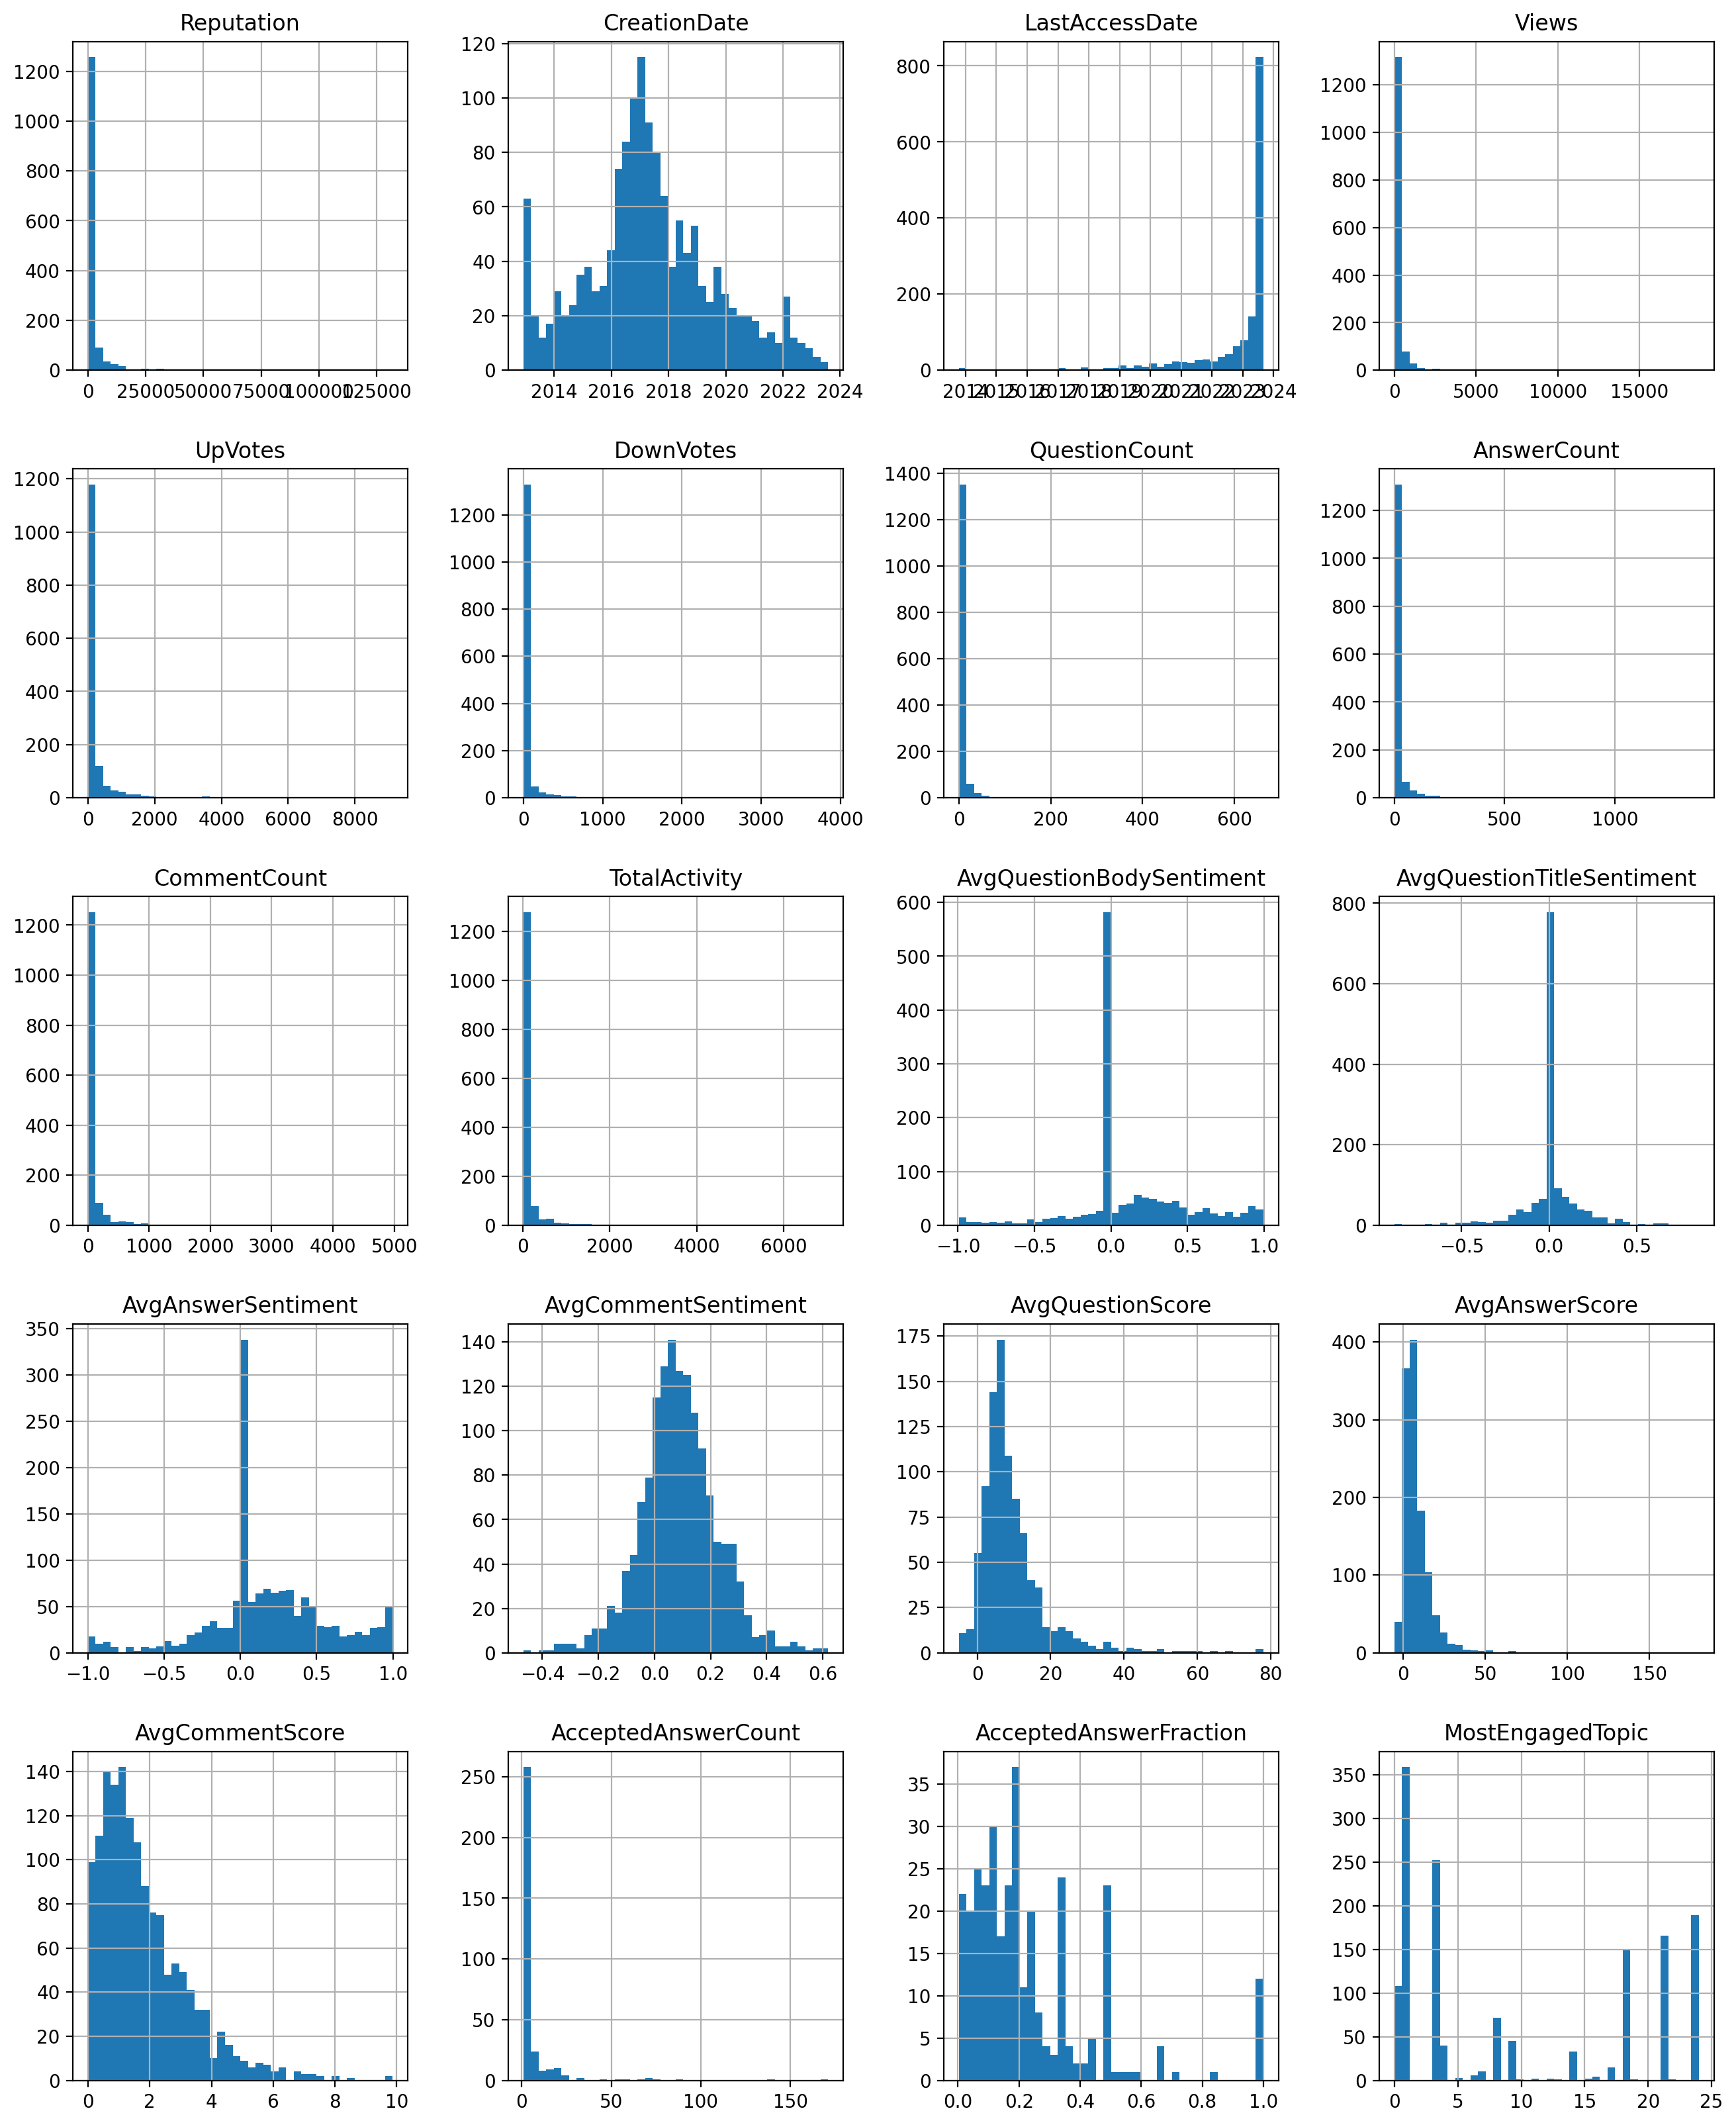

In [4]:
# Display a histogram of specified columns in the dataframe to gain insight into the data
users_with_all_attributes.iloc[:, 1:-26].join(users_with_all_attributes.iloc[:, -1]).hist(bins=40, figsize=(16, 20))  # Excludes the ID column and single-topic engagement columns

plt.show()

In [5]:
def custom_cluster(df, clustering_features, n_clusters, clustering_name, random_state=42, verbose=False, minmax=True):
    '''
    This function accepts a DataFrame, a list of features for clustering, and a clustering name. It performs k-means
    clustering based on the specified features and appends a new column with clustering labels to the DataFrame.
    
    To determine the optimal number of clusters, you can run the function with any value for n_clusters and set verbose to True. 
    This will generate elbow method and silhouette analysis plots. After inspecting these plots, you can rerun 
    the function with n_clusters set to the optimal number of clusters.

    When verbose is enabled, the function also provides additional plots:
    * Distributions among clusters for each of the clustering features are displayed as boxplots.
    * Lineplots illustrate per-feature normalized values across clusters for each of the clustering features. In these lineplots, 
    the cluster with the highest value for each feature is scaled to 1, the cluster with the lowest value is scaled to 0, 
    and the other clusters are plotted on a normalized scale in between. If minmax is set to False, the lineplot simply includes 
    the value of each cluster for each feature (non-normalised).
    '''
    # Impute NaNs and scale features
    features = df[clustering_features].fillna(0)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    df[clustering_name] = kmeans.fit_predict(scaled_features)

    # Display plots
    if verbose:
        # Elbow method and silhouette analysis
        wcss, silhouette_scores = [], []
        for i in range(1, 11):
            kmeans_i = KMeans(n_clusters=i, random_state=random_state).fit(scaled_features)
            wcss.append(kmeans_i.inertia_)
            if i > 1:
                score = silhouette_score(scaled_features, kmeans_i.labels_)
                silhouette_scores.append(score)

        # Plot elbow method and silhouette analysis results
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].plot(range(1, 11), wcss)
        axs[0].set_title('Elbow Method')
        axs[0].set_xlabel('Number of Clusters')
        axs[0].set_ylabel('WCSS')
        axs[0].grid(True)

        axs[1].plot(range(2, 11), silhouette_scores)
        axs[1].set_title('Silhouette Analysis')
        axs[1].set_xlabel('Number of Clusters')
        axs[1].set_ylabel('Silhouette Score')
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

        # Plot boxplots of feature distributions
        num_features = len(clustering_features)
        num_rows = (num_features - 1) // 5 + 1
        num_cols = min(num_features, 5)
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
        axs = axs.flatten() if num_features > 1 else [axs]
        for i, feature in enumerate(clustering_features):
            sns.boxplot(x=clustering_name, y=feature, data=df, ax=axs[i])
            axs[i].set(title=f'{feature} Distribution', xlabel='Cluster', ylabel='Count')
        for ax in axs[len(clustering_features):]:
            ax.set_visible(False)
        plt.tight_layout()
        plt.show()

    # Compute cluster information
    cluster_counts = df[clustering_name].value_counts().sort_index().reset_index(name='Count')
    cluster_means = df.groupby(clustering_name)[clustering_features].mean().add_suffix('Mean')
    cluster_info = pd.merge(cluster_counts, cluster_means, on=clustering_name)

    # Plot lineplot of cluster information
    if verbose:
        if minmax:  # MinMax scaling for lineplot
            minmax_scaler = MinMaxScaler()
            mean_feature_names = [f'{feature}Mean' for feature in clustering_features]
            scaled = cluster_info[mean_feature_names].apply(lambda x: minmax_scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
            scaled[clustering_name] = cluster_info[clustering_name]
            melted = scaled.melt(id_vars=[clustering_name], var_name='Feature', value_name='NormalizedValue')
            ylabel = "Per-Feature Normalised Value"
        else:  # Absolute values for lineplot
            melted = cluster_info.drop('Count', axis=1).melt(id_vars=[clustering_name], var_name='Feature', value_name='Mean')
            ylabel = "Mean Value"

        plt.figure(figsize=(10, 5))
        value_column = 'NormalizedValue' if minmax else 'Mean'
        title = "Per-Feature Normalised Values Across Clusters" if minmax else "Mean Values of Features Across Clusters"
        for cluster in melted[clustering_name].unique():
            data = melted[melted[clustering_name] == cluster]
            plt.plot(data['Feature'], data[value_column], label=f'Cluster {cluster}')
        plt.title(title)
        plt.xlabel("Feature")
        plt.ylabel(ylabel)
        plt.xticks(rotation=45)
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

    return cluster_info

In [6]:
def permutation_test_clustering(df, clustering_name, clustering_features, num_permutations=1000, verbose=False):
    '''
    This function accepts a DataFrame, a clustering name, and a list of features for clustering. It performs a permutation 
    test to assess the significance of a clustering algorithm's performance using the silhouette score.
    '''
    # Impute NaNs and scale features
    features = df[clustering_features].fillna(0)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Compute silhouette score using actual labels
    actual_labels = df[clustering_name].values
    actual_silhouette_score = silhouette_score(scaled_features, actual_labels)
    
    # Compute silhouette scores using permuted labels
    permuted_silhouette_scores = []
    for _ in range(num_permutations):
        shuffled_labels = np.random.permutation(actual_labels)
        permuted_silhouette_score = silhouette_score(scaled_features, shuffled_labels)
        permuted_silhouette_scores.append(permuted_silhouette_score)

    # Calculate p-value for significance testing
    p_value = (np.sum(np.array(permuted_silhouette_scores) >= actual_silhouette_score) + 1) / (num_permutations + 1)

    if verbose:
        print(f'Actual silhouette score: {actual_silhouette_score}')
        print(f'p-value: {p_value}')

    return actual_silhouette_score, p_value

### 1. Clustering by Activity Metrics

#### 1.1 Clustering by question count, answer count, and comment count

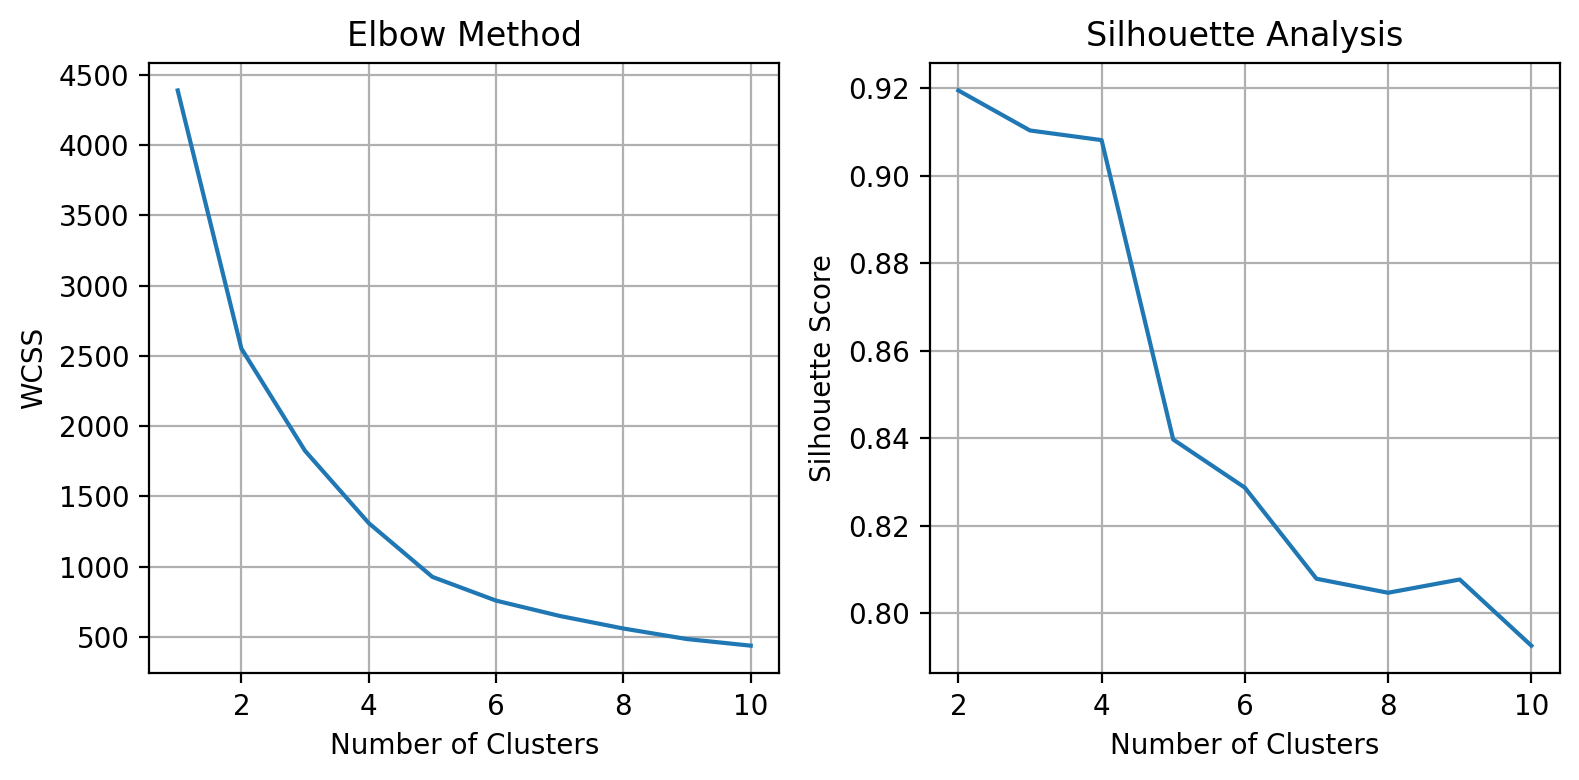

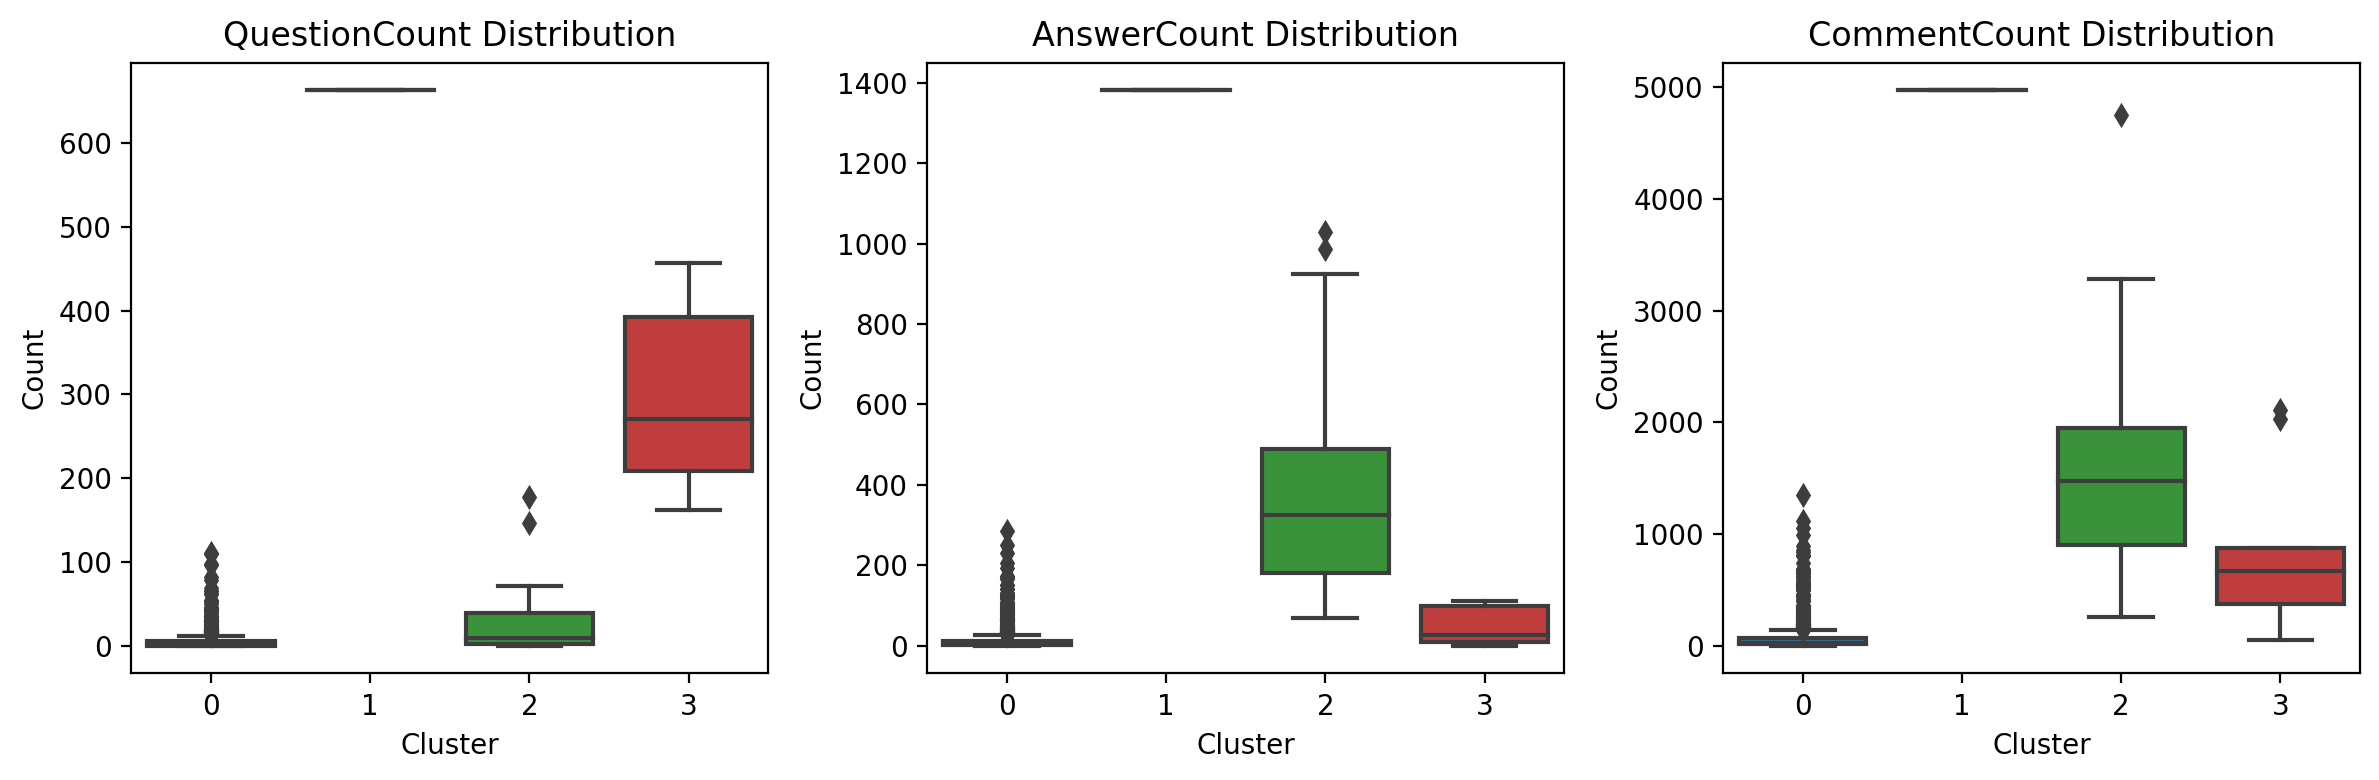

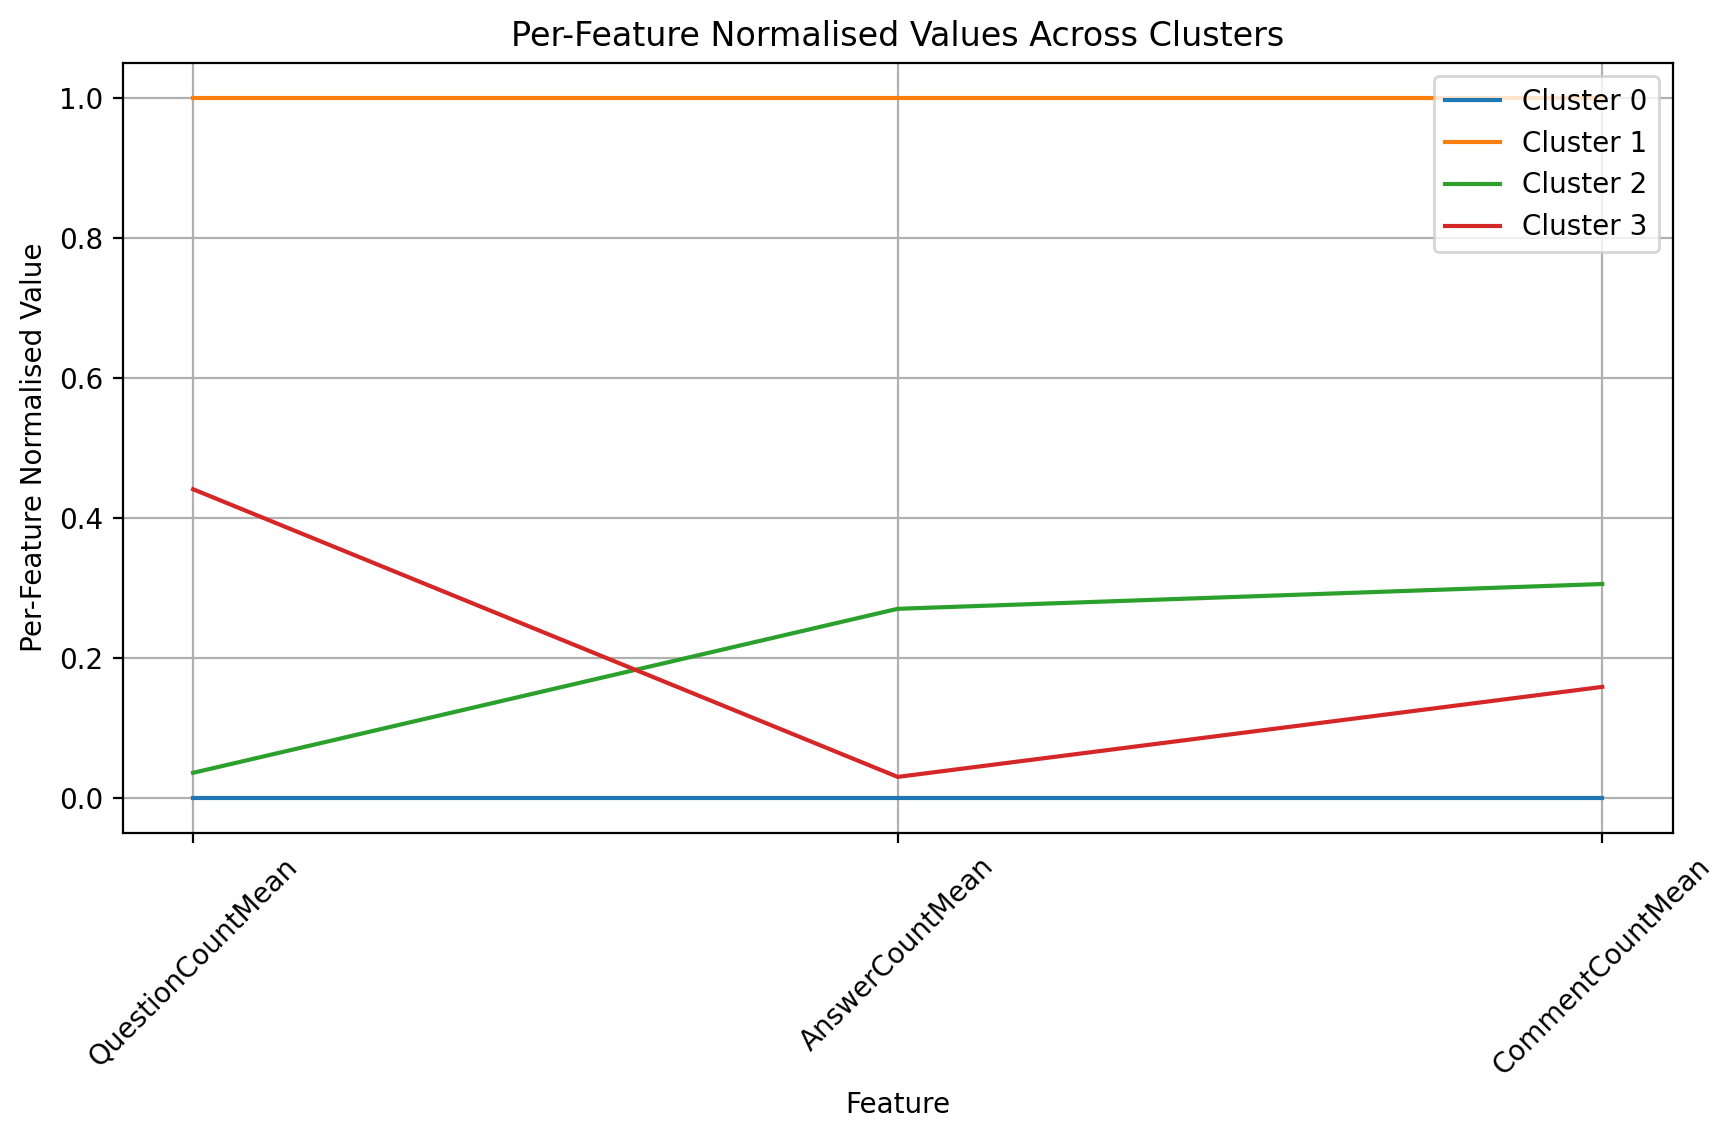

ActivityCluster  Count  QuestionCountMean  AnswerCountMean  \
0                0   1424           4.517556        12.245787   
1                1      1         663.000000      1381.000000   
2                2     29          27.827586       381.344828   
3                3      9         294.555556        52.666667   

   CommentCountMean  
0         70.413624  
1       4972.000000  
2       1565.896552  
3        845.555556

In [7]:
clustering_features = ['QuestionCount', 'AnswerCount', 'CommentCount']
clustering_name = 'ActivityCluster'

custom_cluster(users_with_all_attributes, clustering_features, 4, clustering_name, verbose=True)

In [8]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.9081609059757761
p-value: 0.000999000999000999


### 2. Clustering by Quality Metrics

#### 2.1 Clustering by reputation, average question score, average answer score, and average comment score

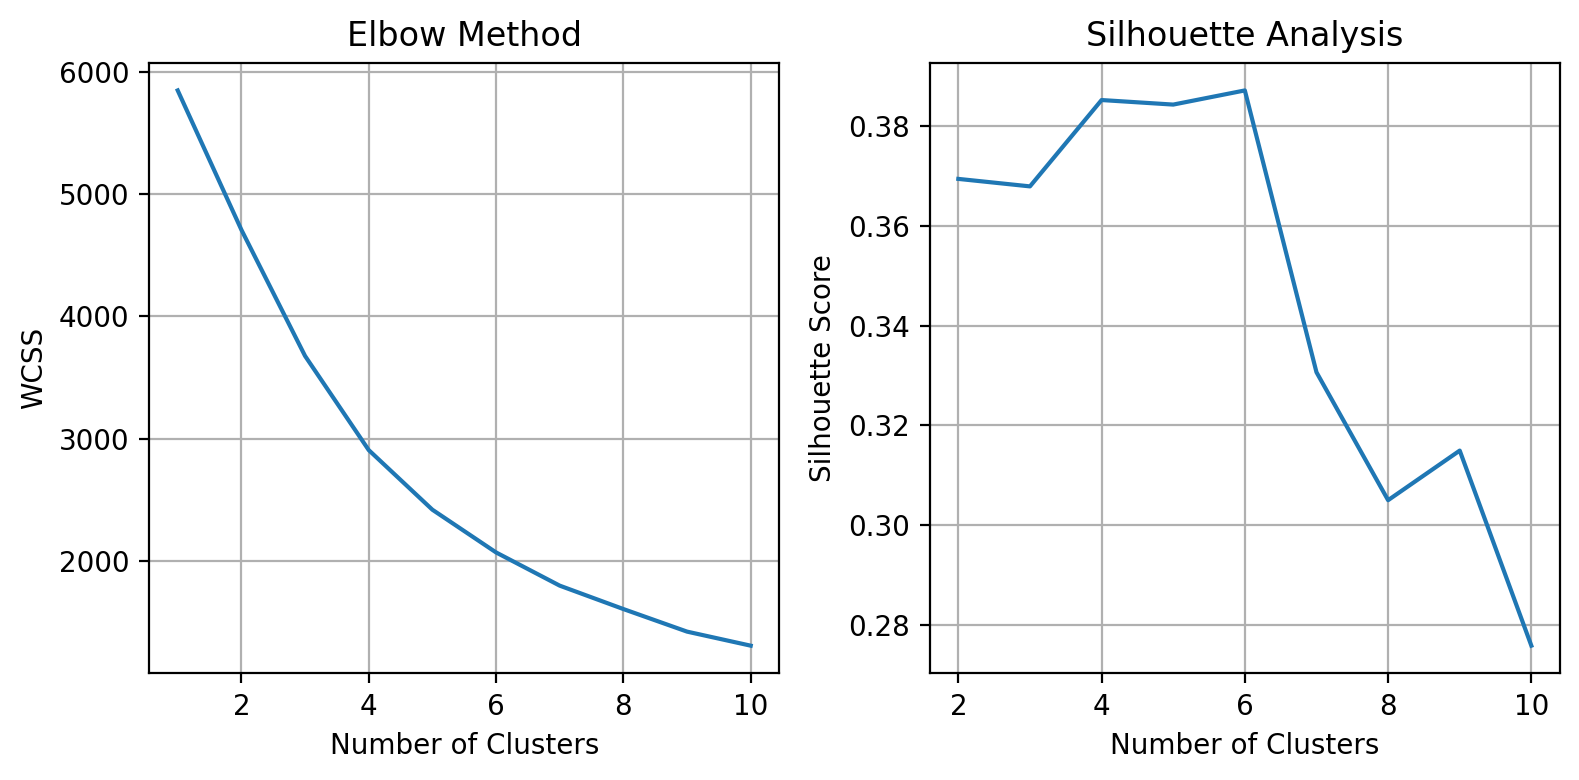

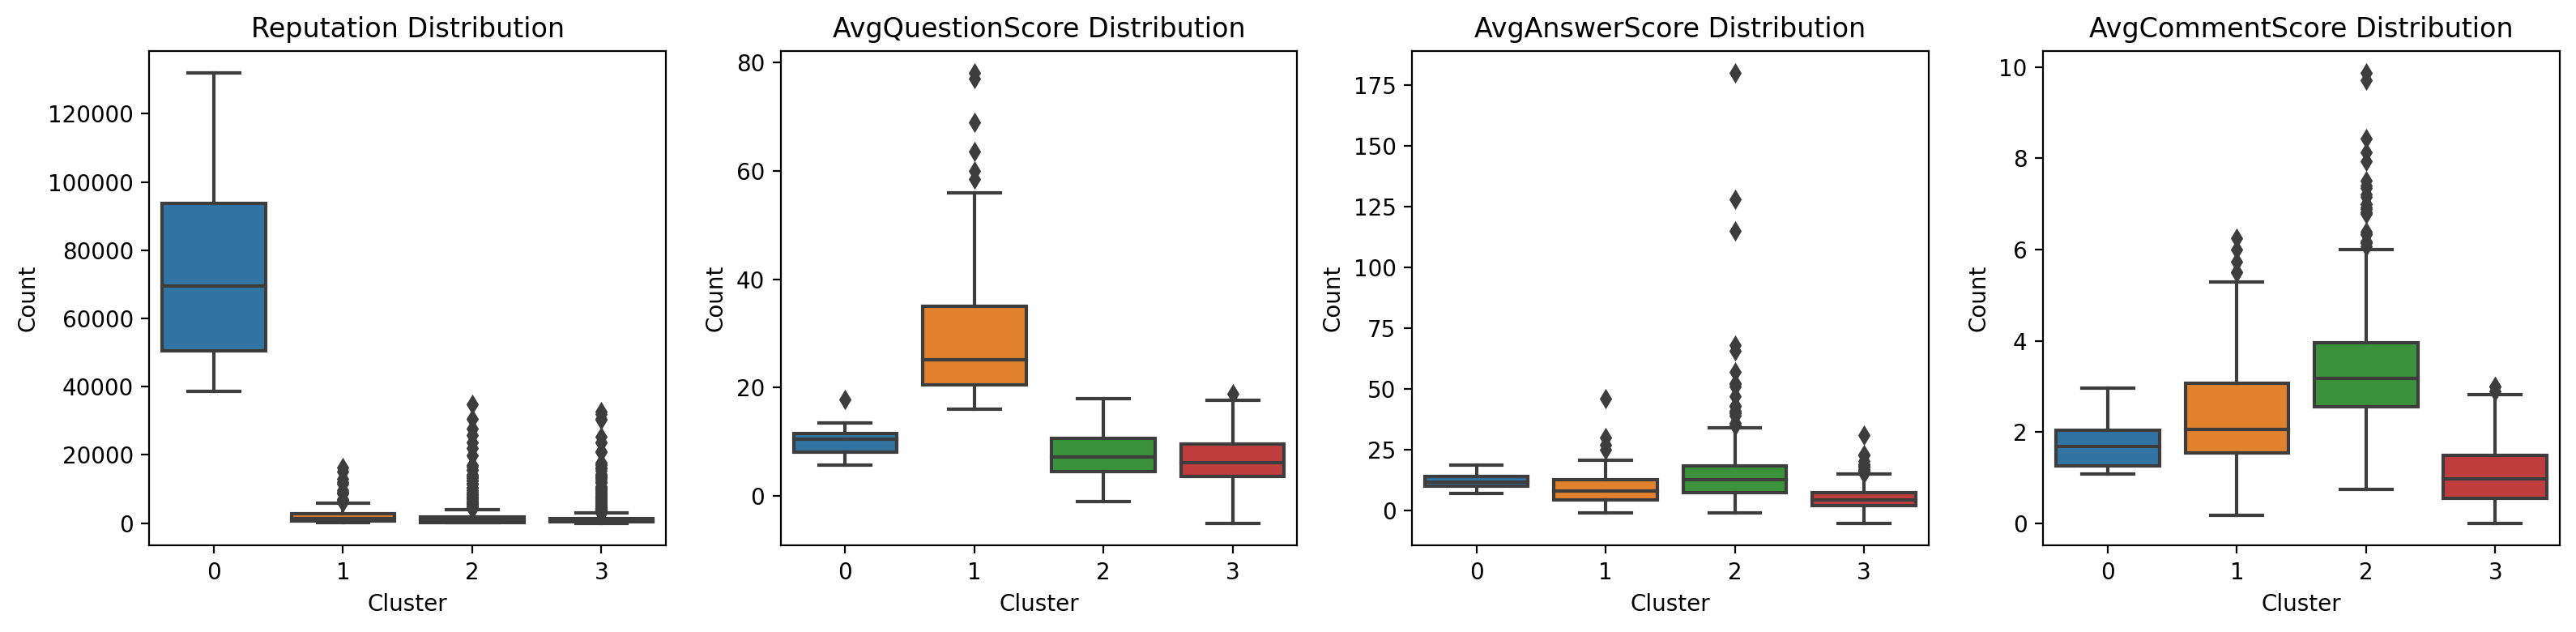

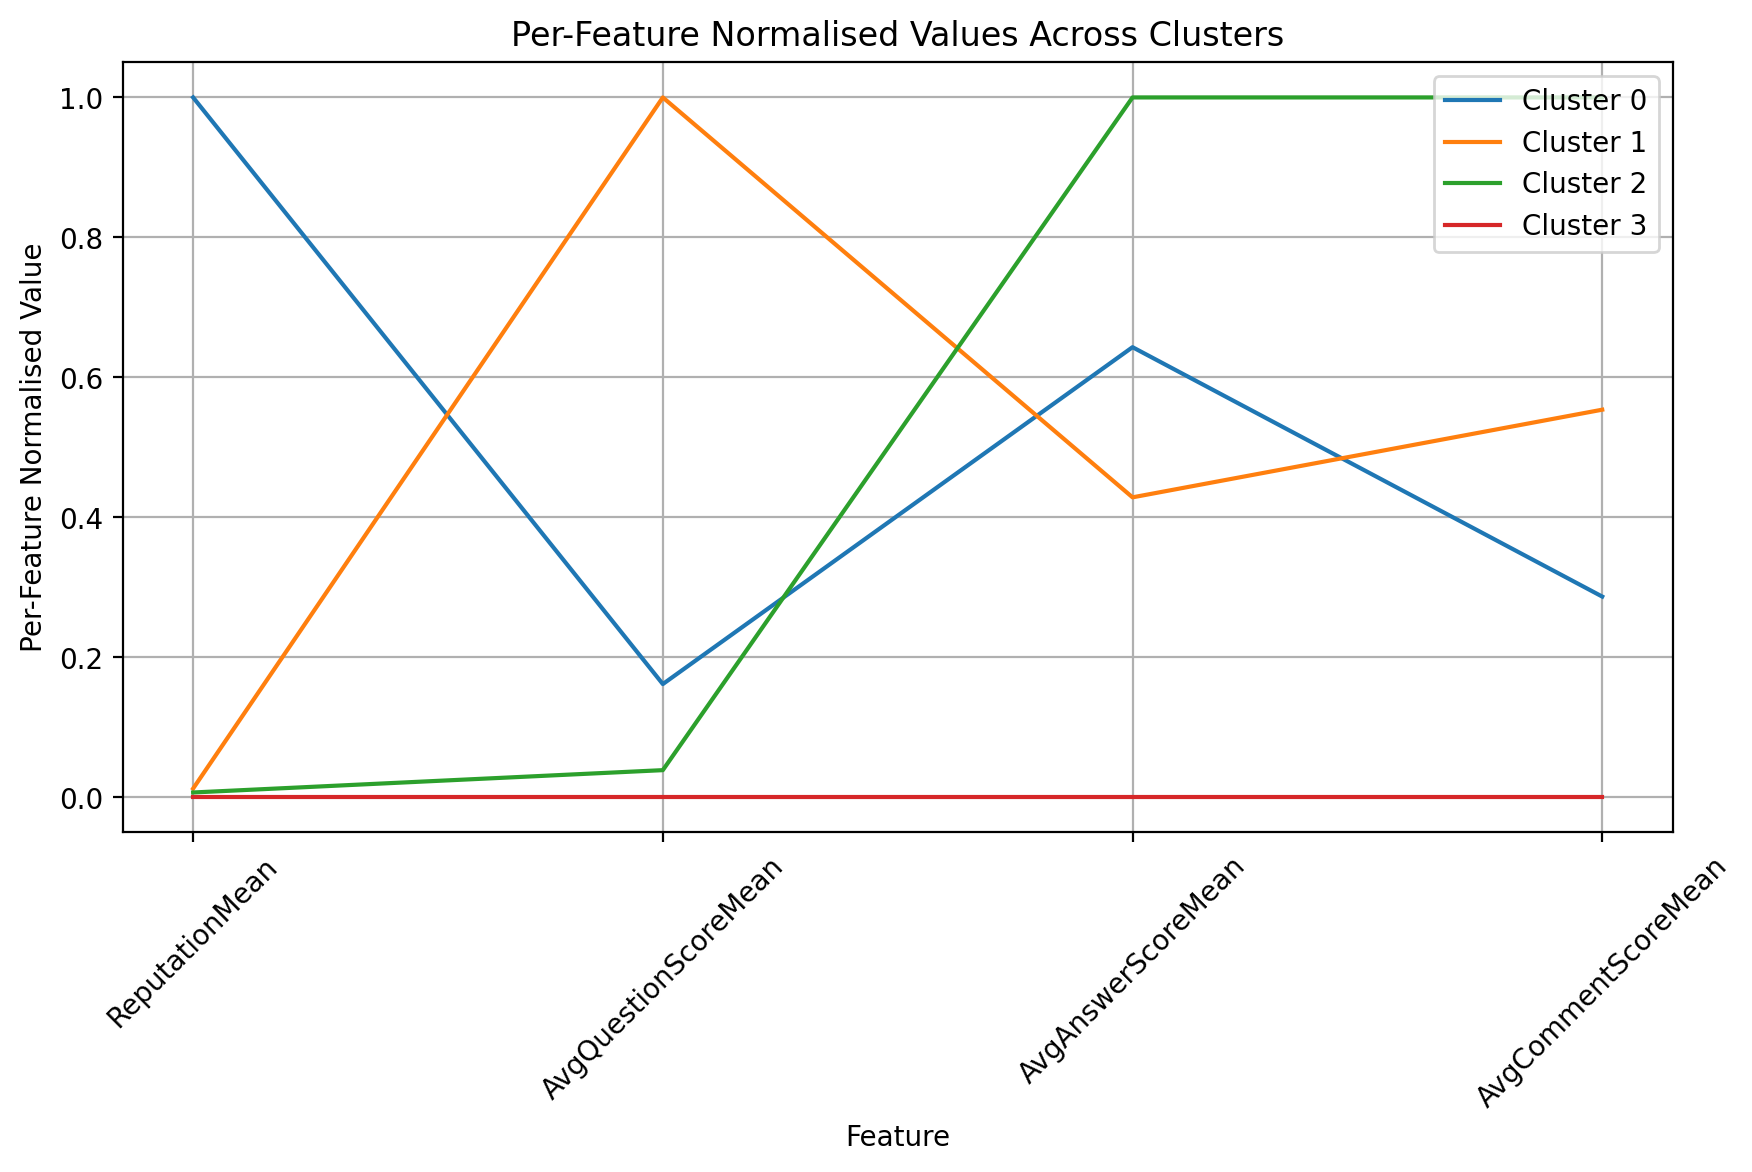

QualityCluster1  Count  ReputationMean  AvgQuestionScoreMean  \
0                0     16    74118.812500             10.385368   
1                1    105     2632.095238             29.546801   
2                2    409     2223.853301              7.573918   
3                3    933     1711.833869              6.682733   

   AvgAnswerScoreMean  AvgCommentScoreMean  
0           11.852085             1.729446  
1            9.559383             2.368631  
2           15.665143             3.436663  
3            4.977559             1.042431

In [9]:
clustering_features = ['Reputation', 'AvgQuestionScore', 'AvgAnswerScore', 'AvgCommentScore']
clustering_name = 'QualityCluster1'

custom_cluster(users_with_all_attributes, clustering_features, 4, clustering_name, verbose=True)

In [10]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.3853100990662119
p-value: 0.000999000999000999


#### 2.2 Clustering by accepted answer count and accepted answer fraction

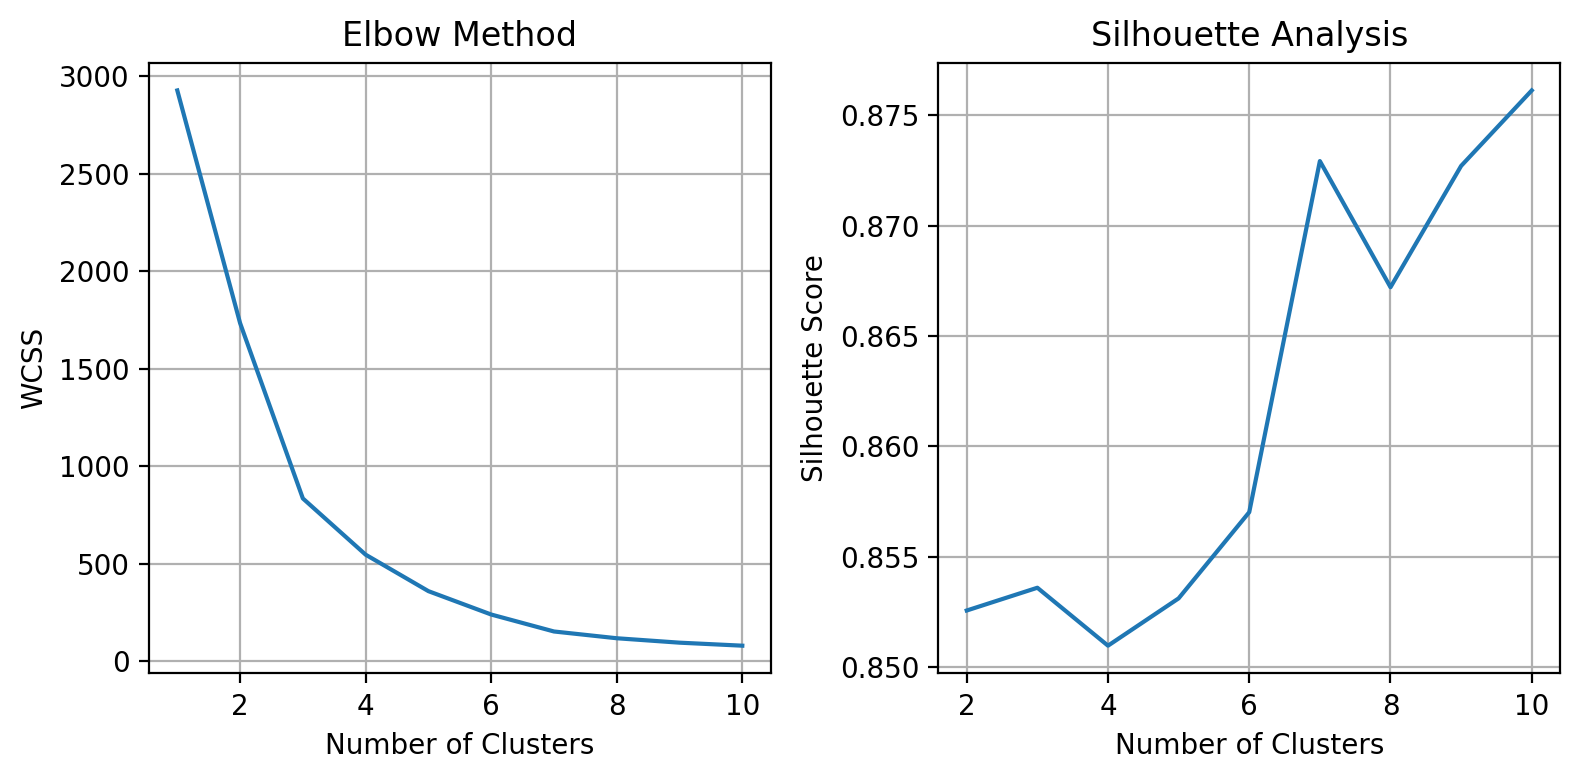

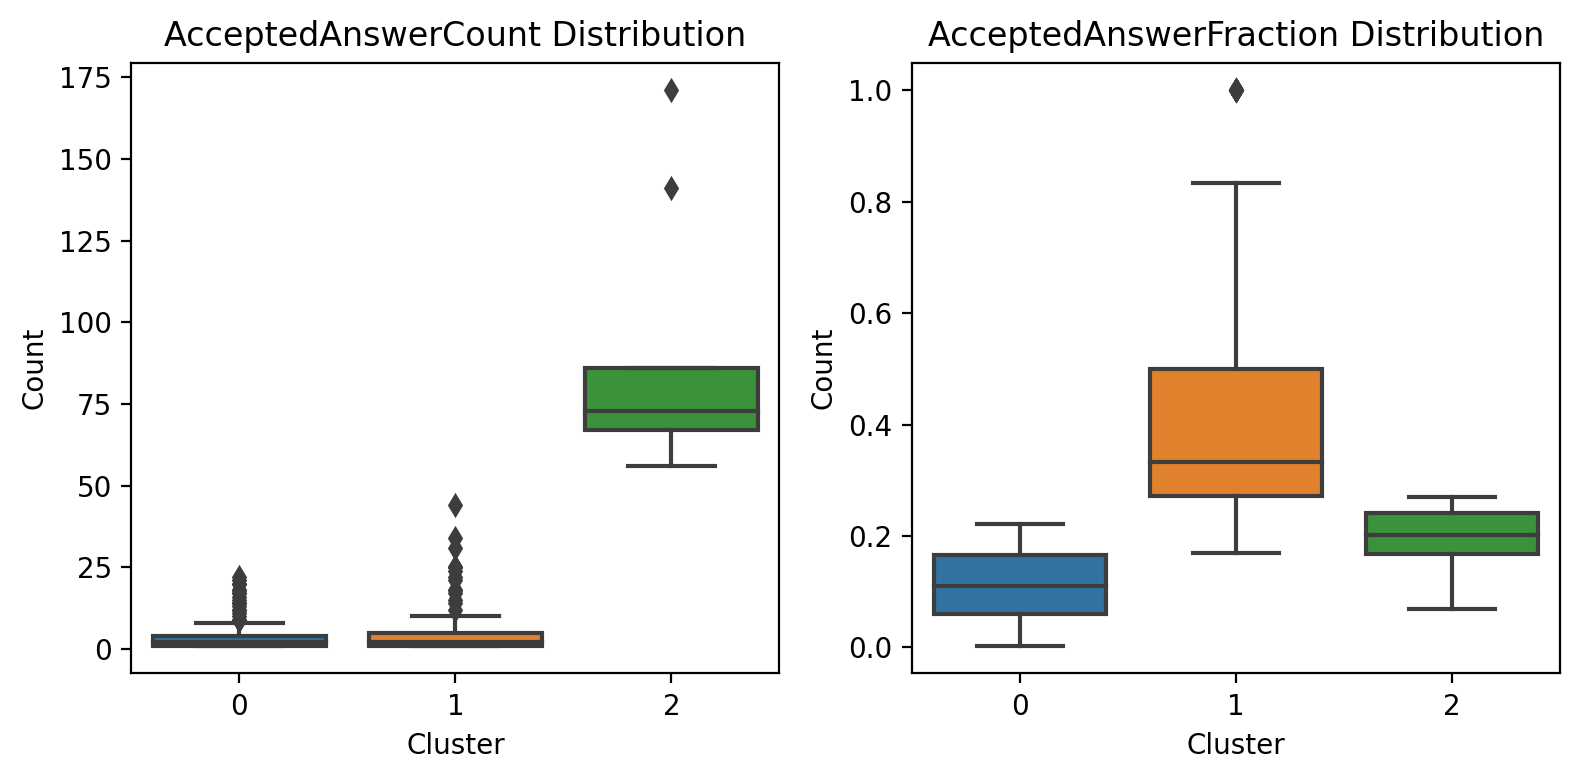

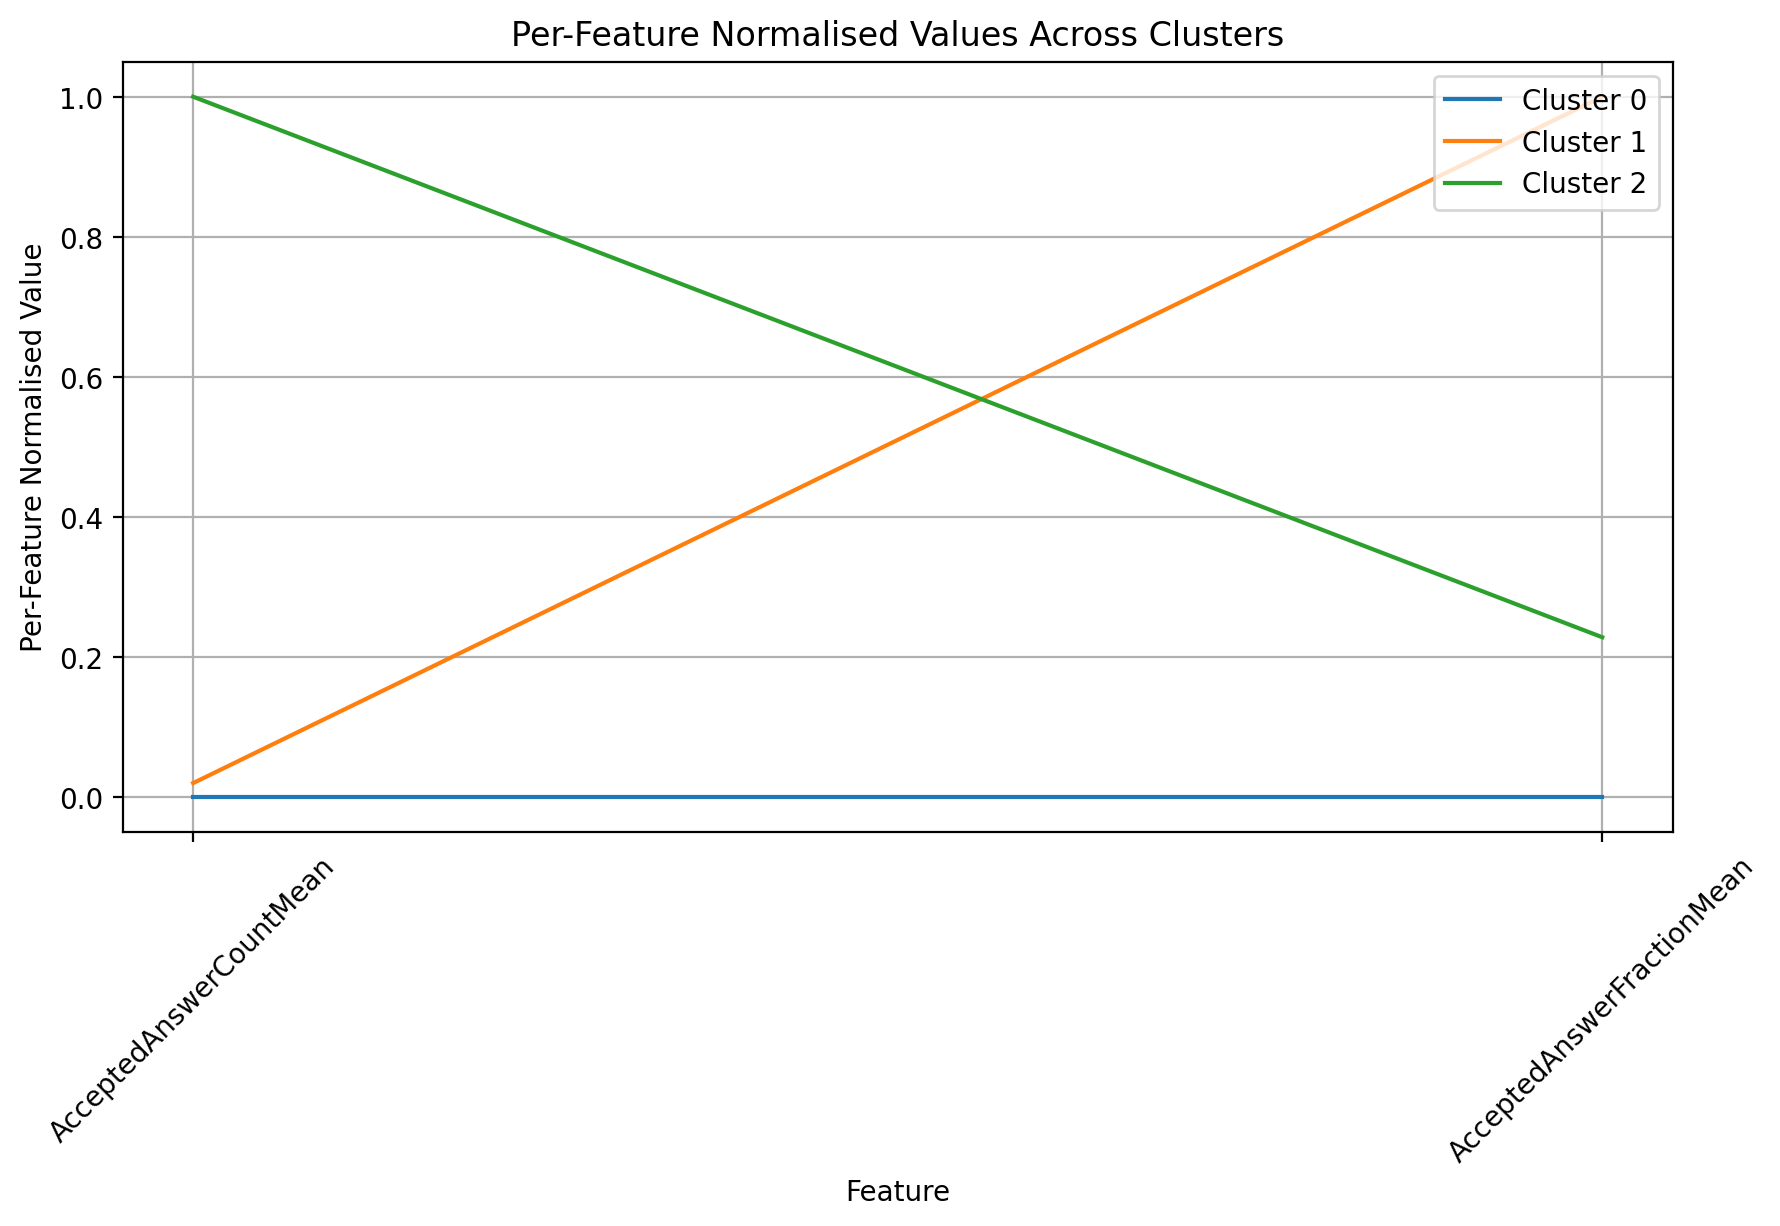

QualityCluster2  Count  AcceptedAnswerCountMean  AcceptedAnswerFractionMean
0                0   1334                 3.505102                    0.112406
1                1    120                 5.166667                    0.440166
2                2      9                88.888889                    0.187083

In [11]:
clustering_features = ['AcceptedAnswerCount', 'AcceptedAnswerFraction']
clustering_name = 'QualityCluster2'

custom_cluster(users_with_all_attributes, clustering_features, 3, clustering_name, verbose=True)

In [12]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.8535996779648711
p-value: 0.000999000999000999


### 3. Clustering by Sentiment Metrics

#### 3.1 Clustering by average question body sentiment, average question title sentiment, average answer sentiment, average comment sentiment

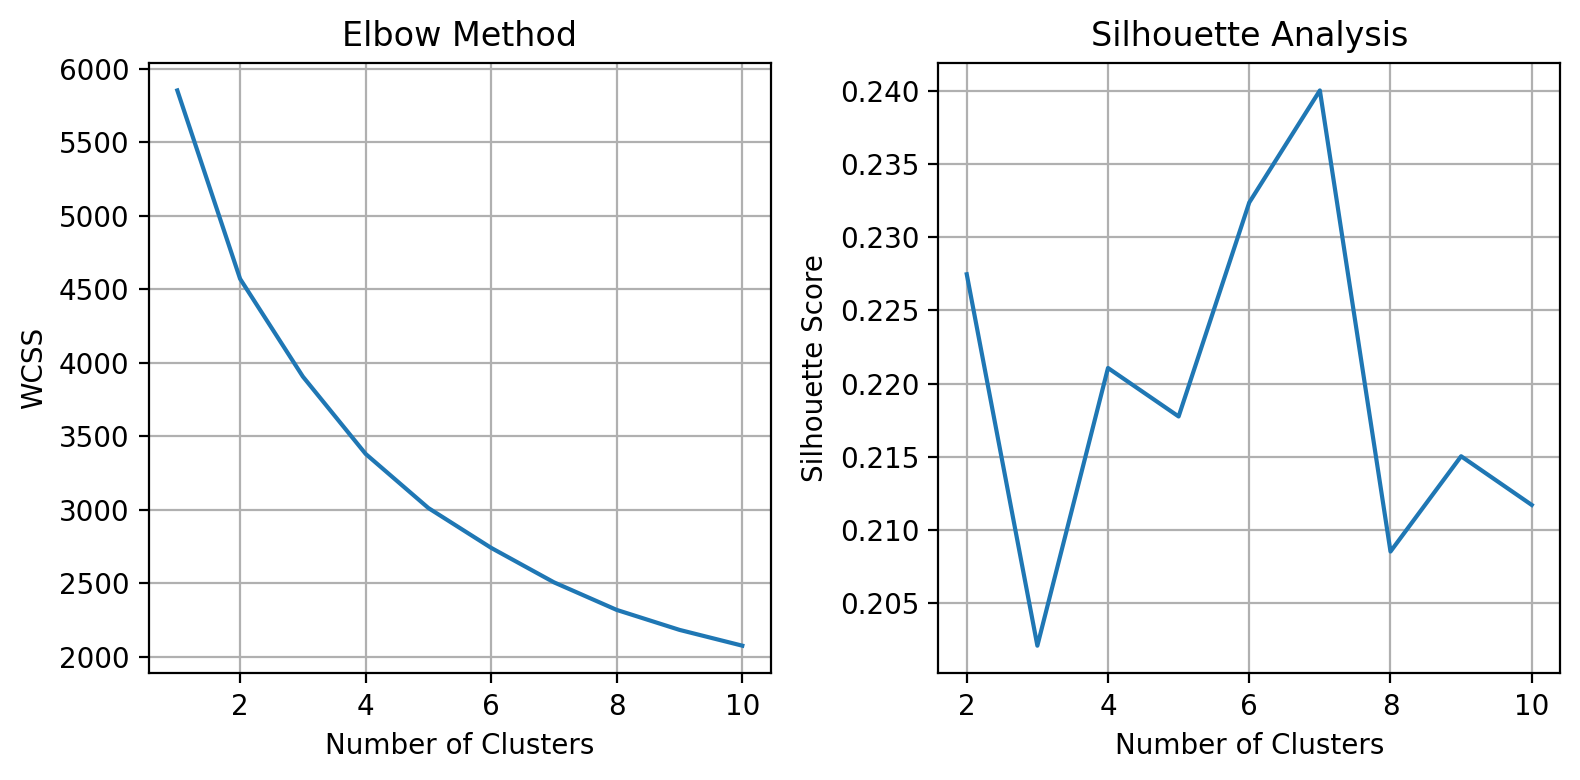

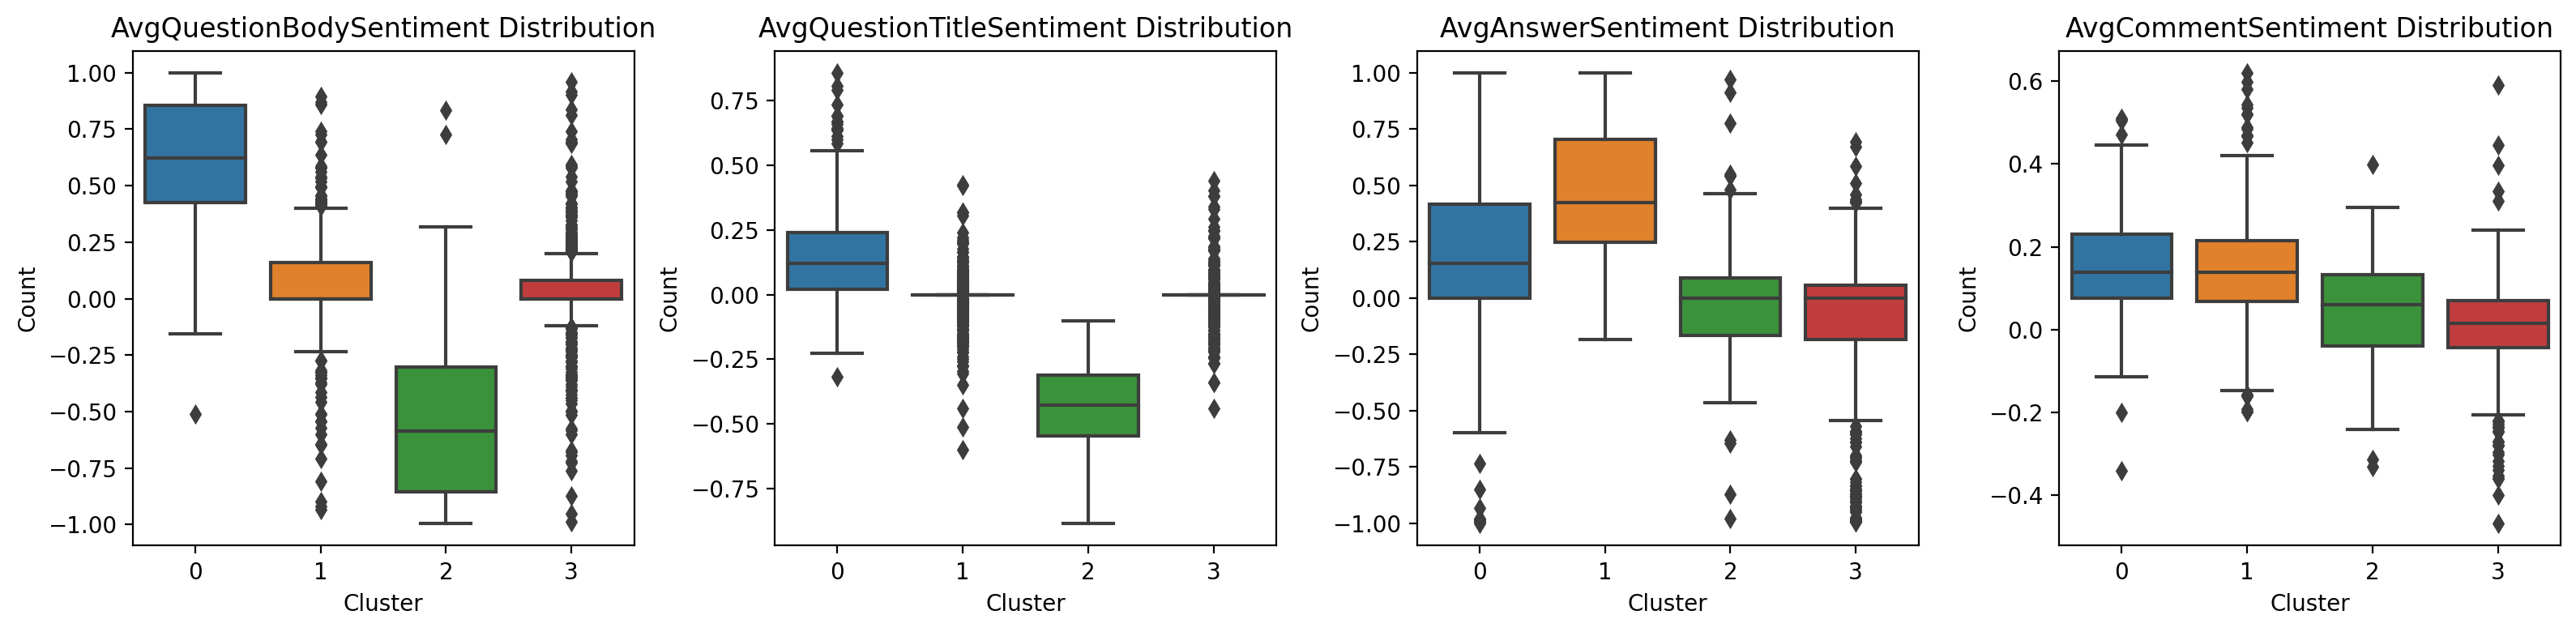

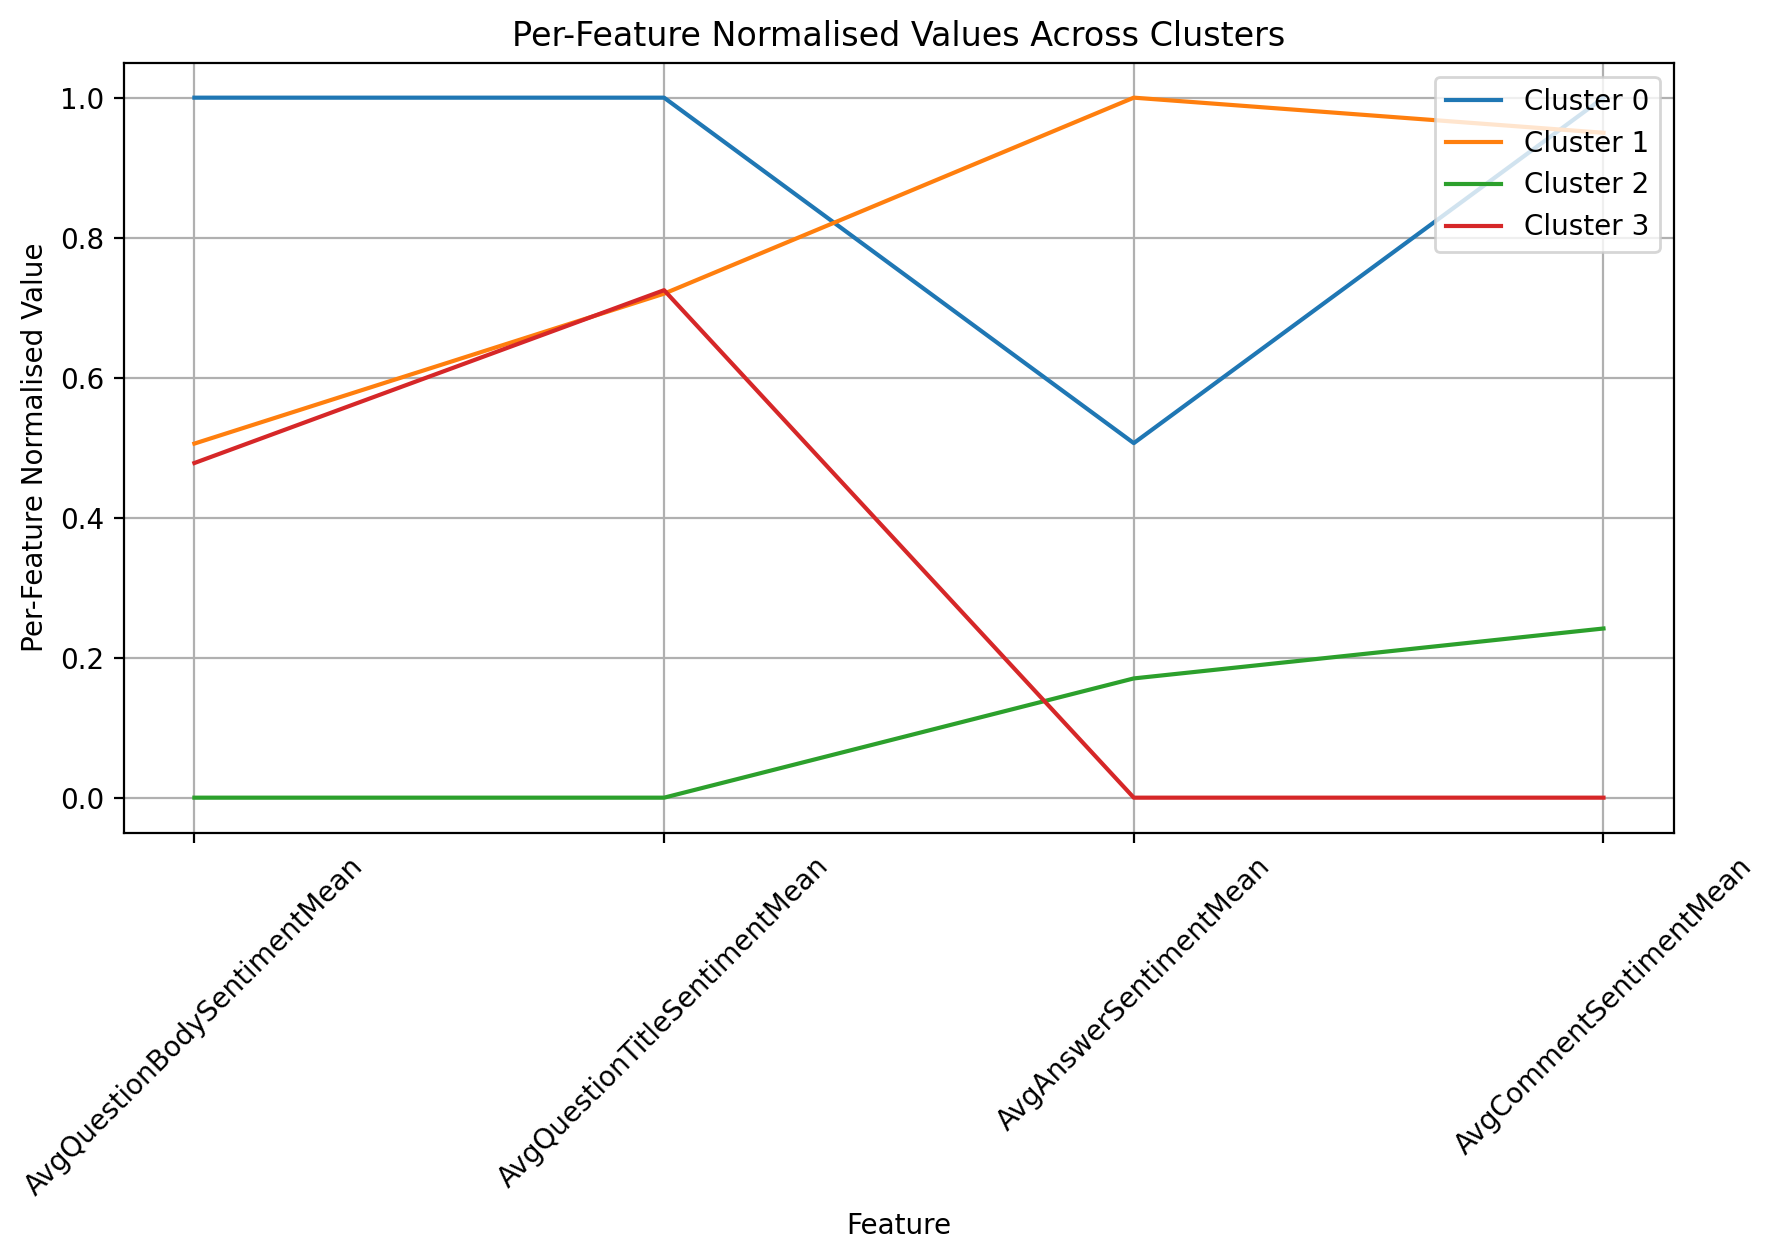

SentimentCluster  Count  AvgQuestionBodySentimentMean  \
0                 0    321                      0.628099   
1                 1    508                      0.058153   
2                 2     72                     -0.525177   
3                 3    562                      0.026148   

   AvgQuestionTitleSentimentMean  AvgAnswerSentimentMean  \
0                       0.161663                0.190884   
1                      -0.007225                0.462271   
2                      -0.441523                0.006057   
3                      -0.004225               -0.087617   

   AvgCommentSentimentMean  
0                 0.151958  
1                 0.144681  
2                 0.041924  
3                 0.006856

In [13]:
clustering_features = ['AvgQuestionBodySentiment', 'AvgQuestionTitleSentiment', 'AvgAnswerSentiment', 'AvgCommentSentiment']
clustering_name = 'SentimentCluster'

custom_cluster(users_with_all_attributes, clustering_features, 4, clustering_name, verbose=True)

In [14]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.22106245349335366
p-value: 0.000999000999000999


### 4. Clustering by Engagement Metrics

#### 4.1 Clustering by views, upvotes, and downvotes

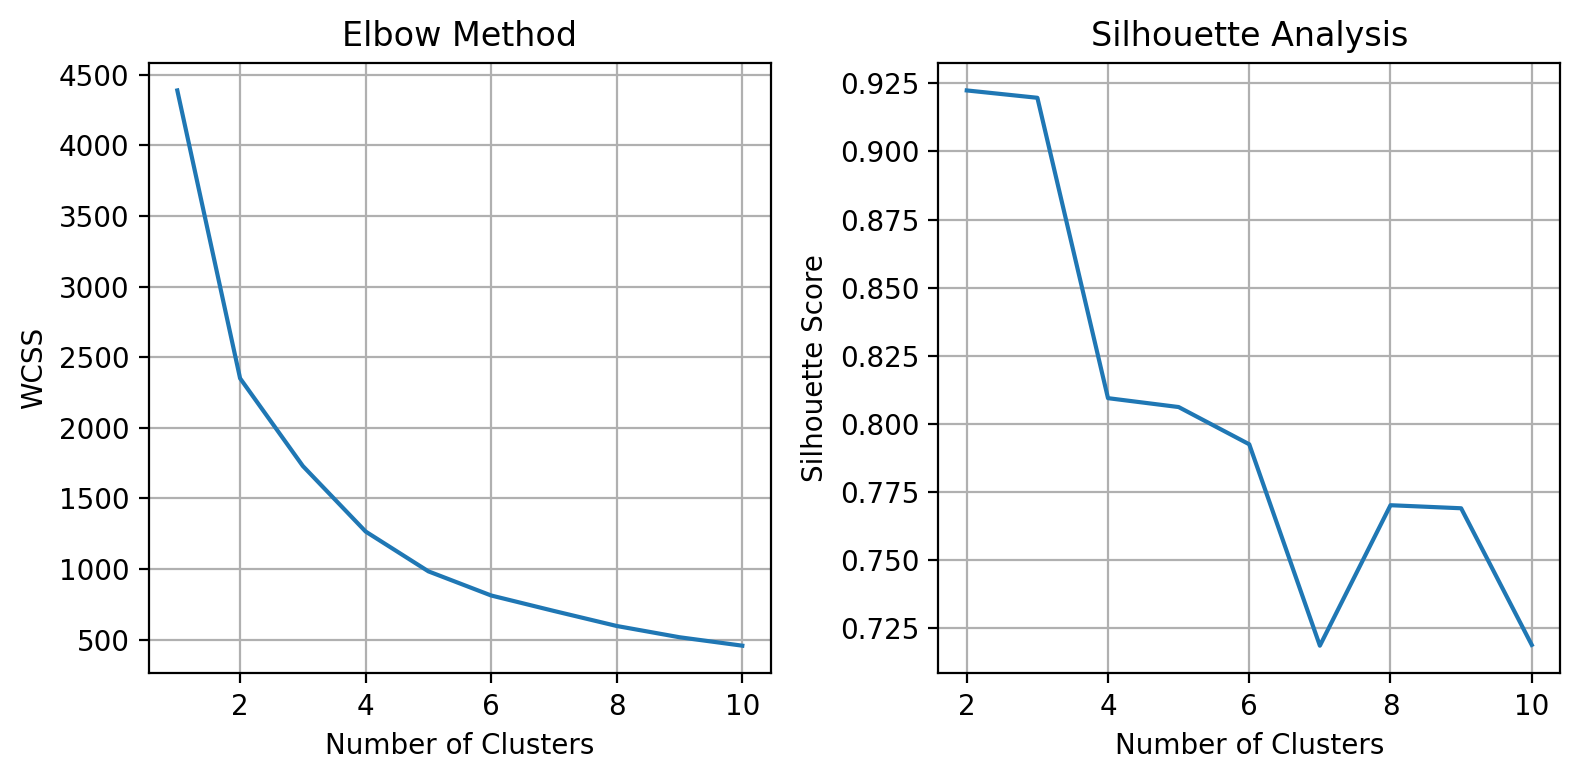

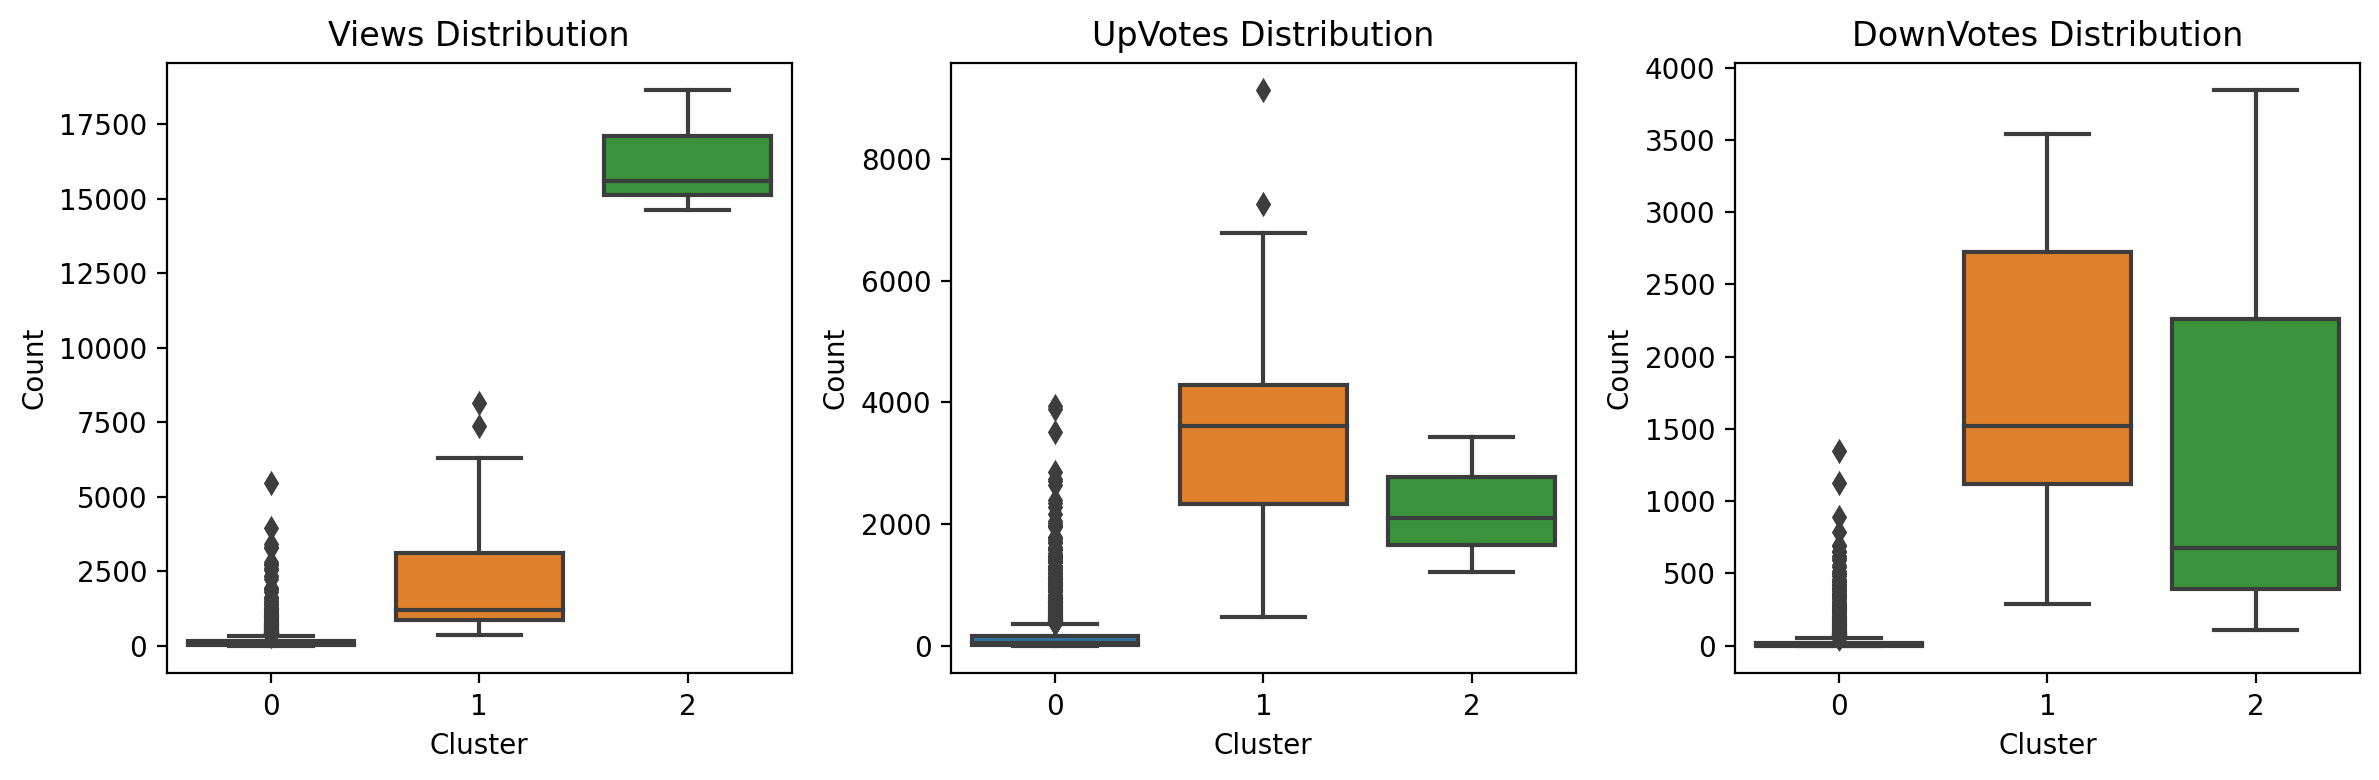

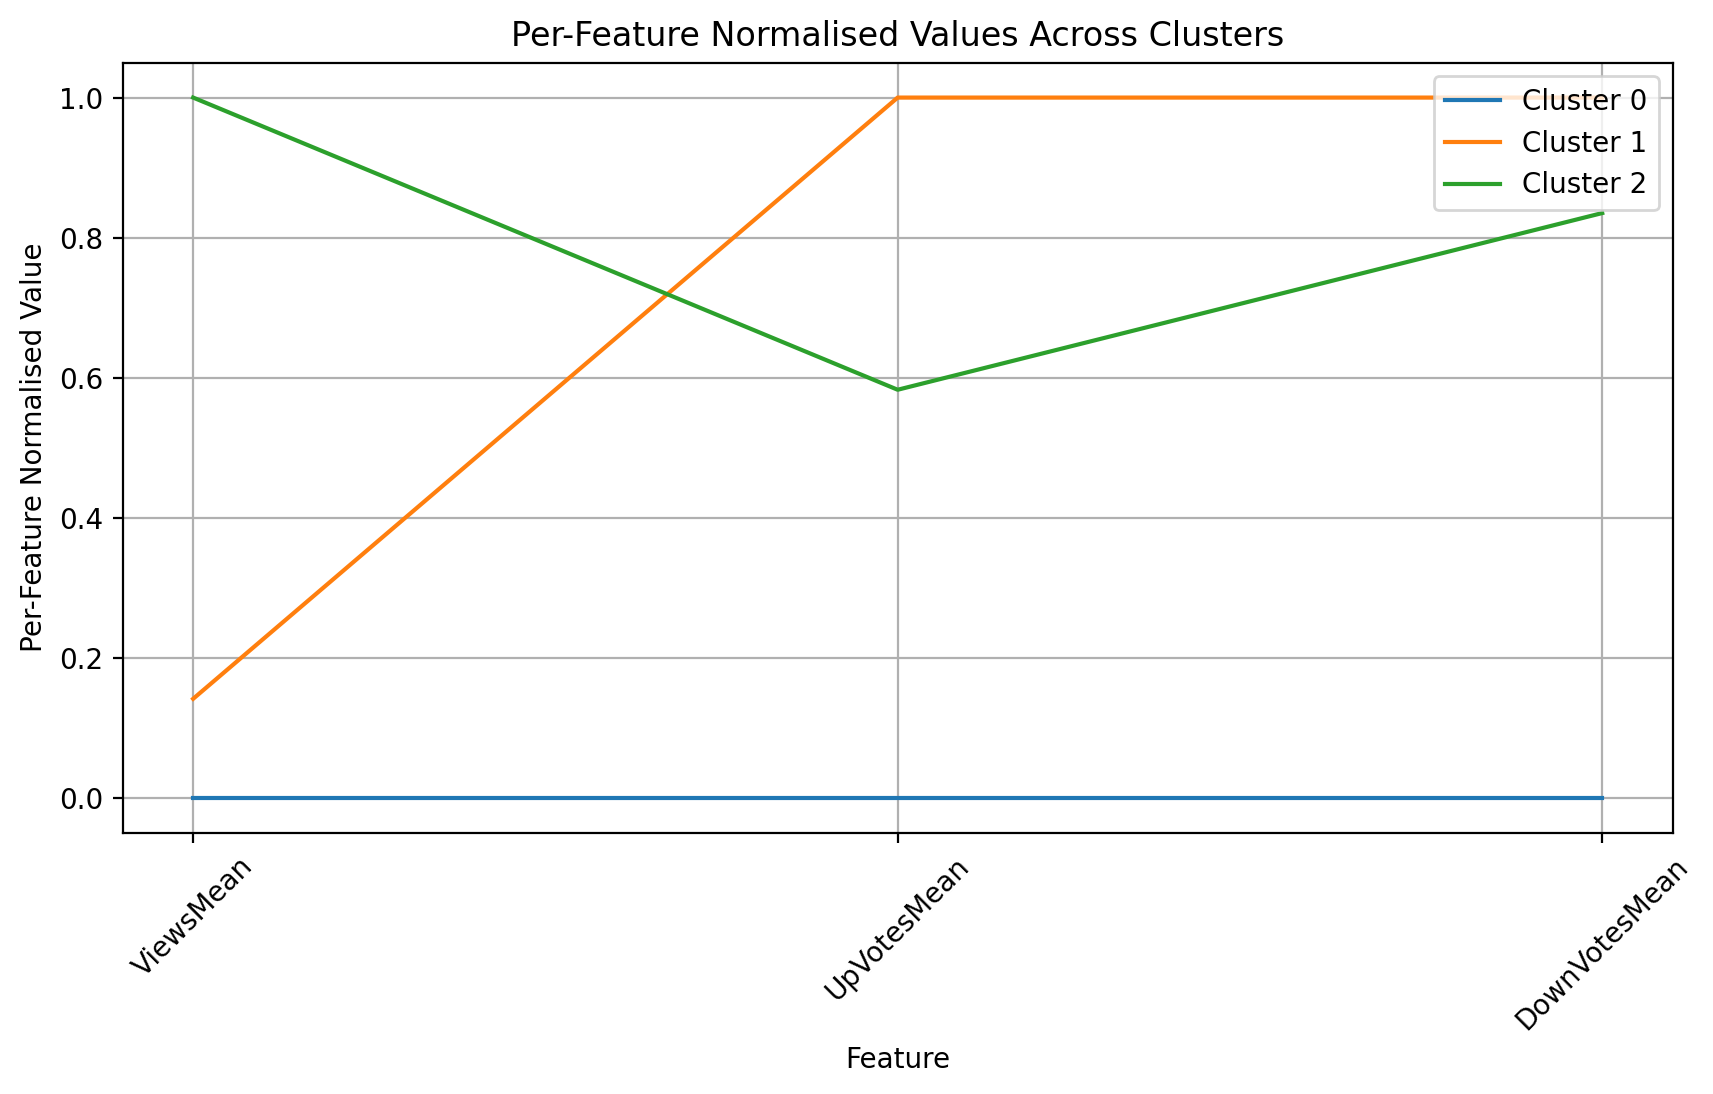

EngagementCluster  Count     ViewsMean  UpVotesMean  DownVotesMean
0                  0   1440    171.065972   179.325694      34.183333
1                  1     20   2444.950000  3738.650000    1840.350000
2                  2      3  16289.666667  2253.000000    1542.333333

In [15]:
clustering_features = ['Views', 'UpVotes', 'DownVotes']
clustering_name = 'EngagementCluster'

custom_cluster(users_with_all_attributes, clustering_features, 3, clustering_name, verbose=True)

In [16]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.9196770389342251
p-value: 0.000999000999000999


### 5. Clustering by Interest Metrics

#### 5.1 Clustering by topic engagement columns

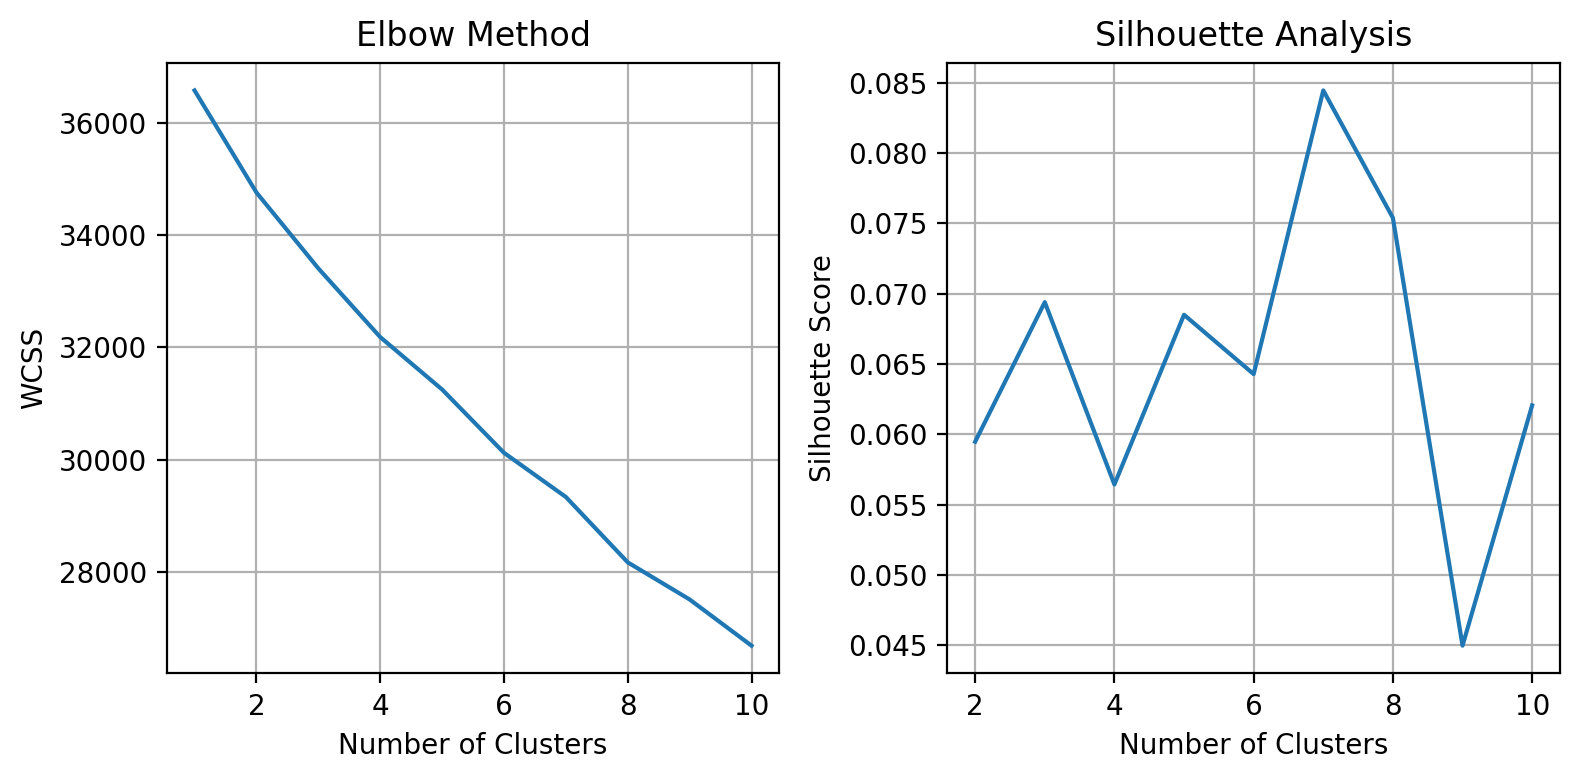

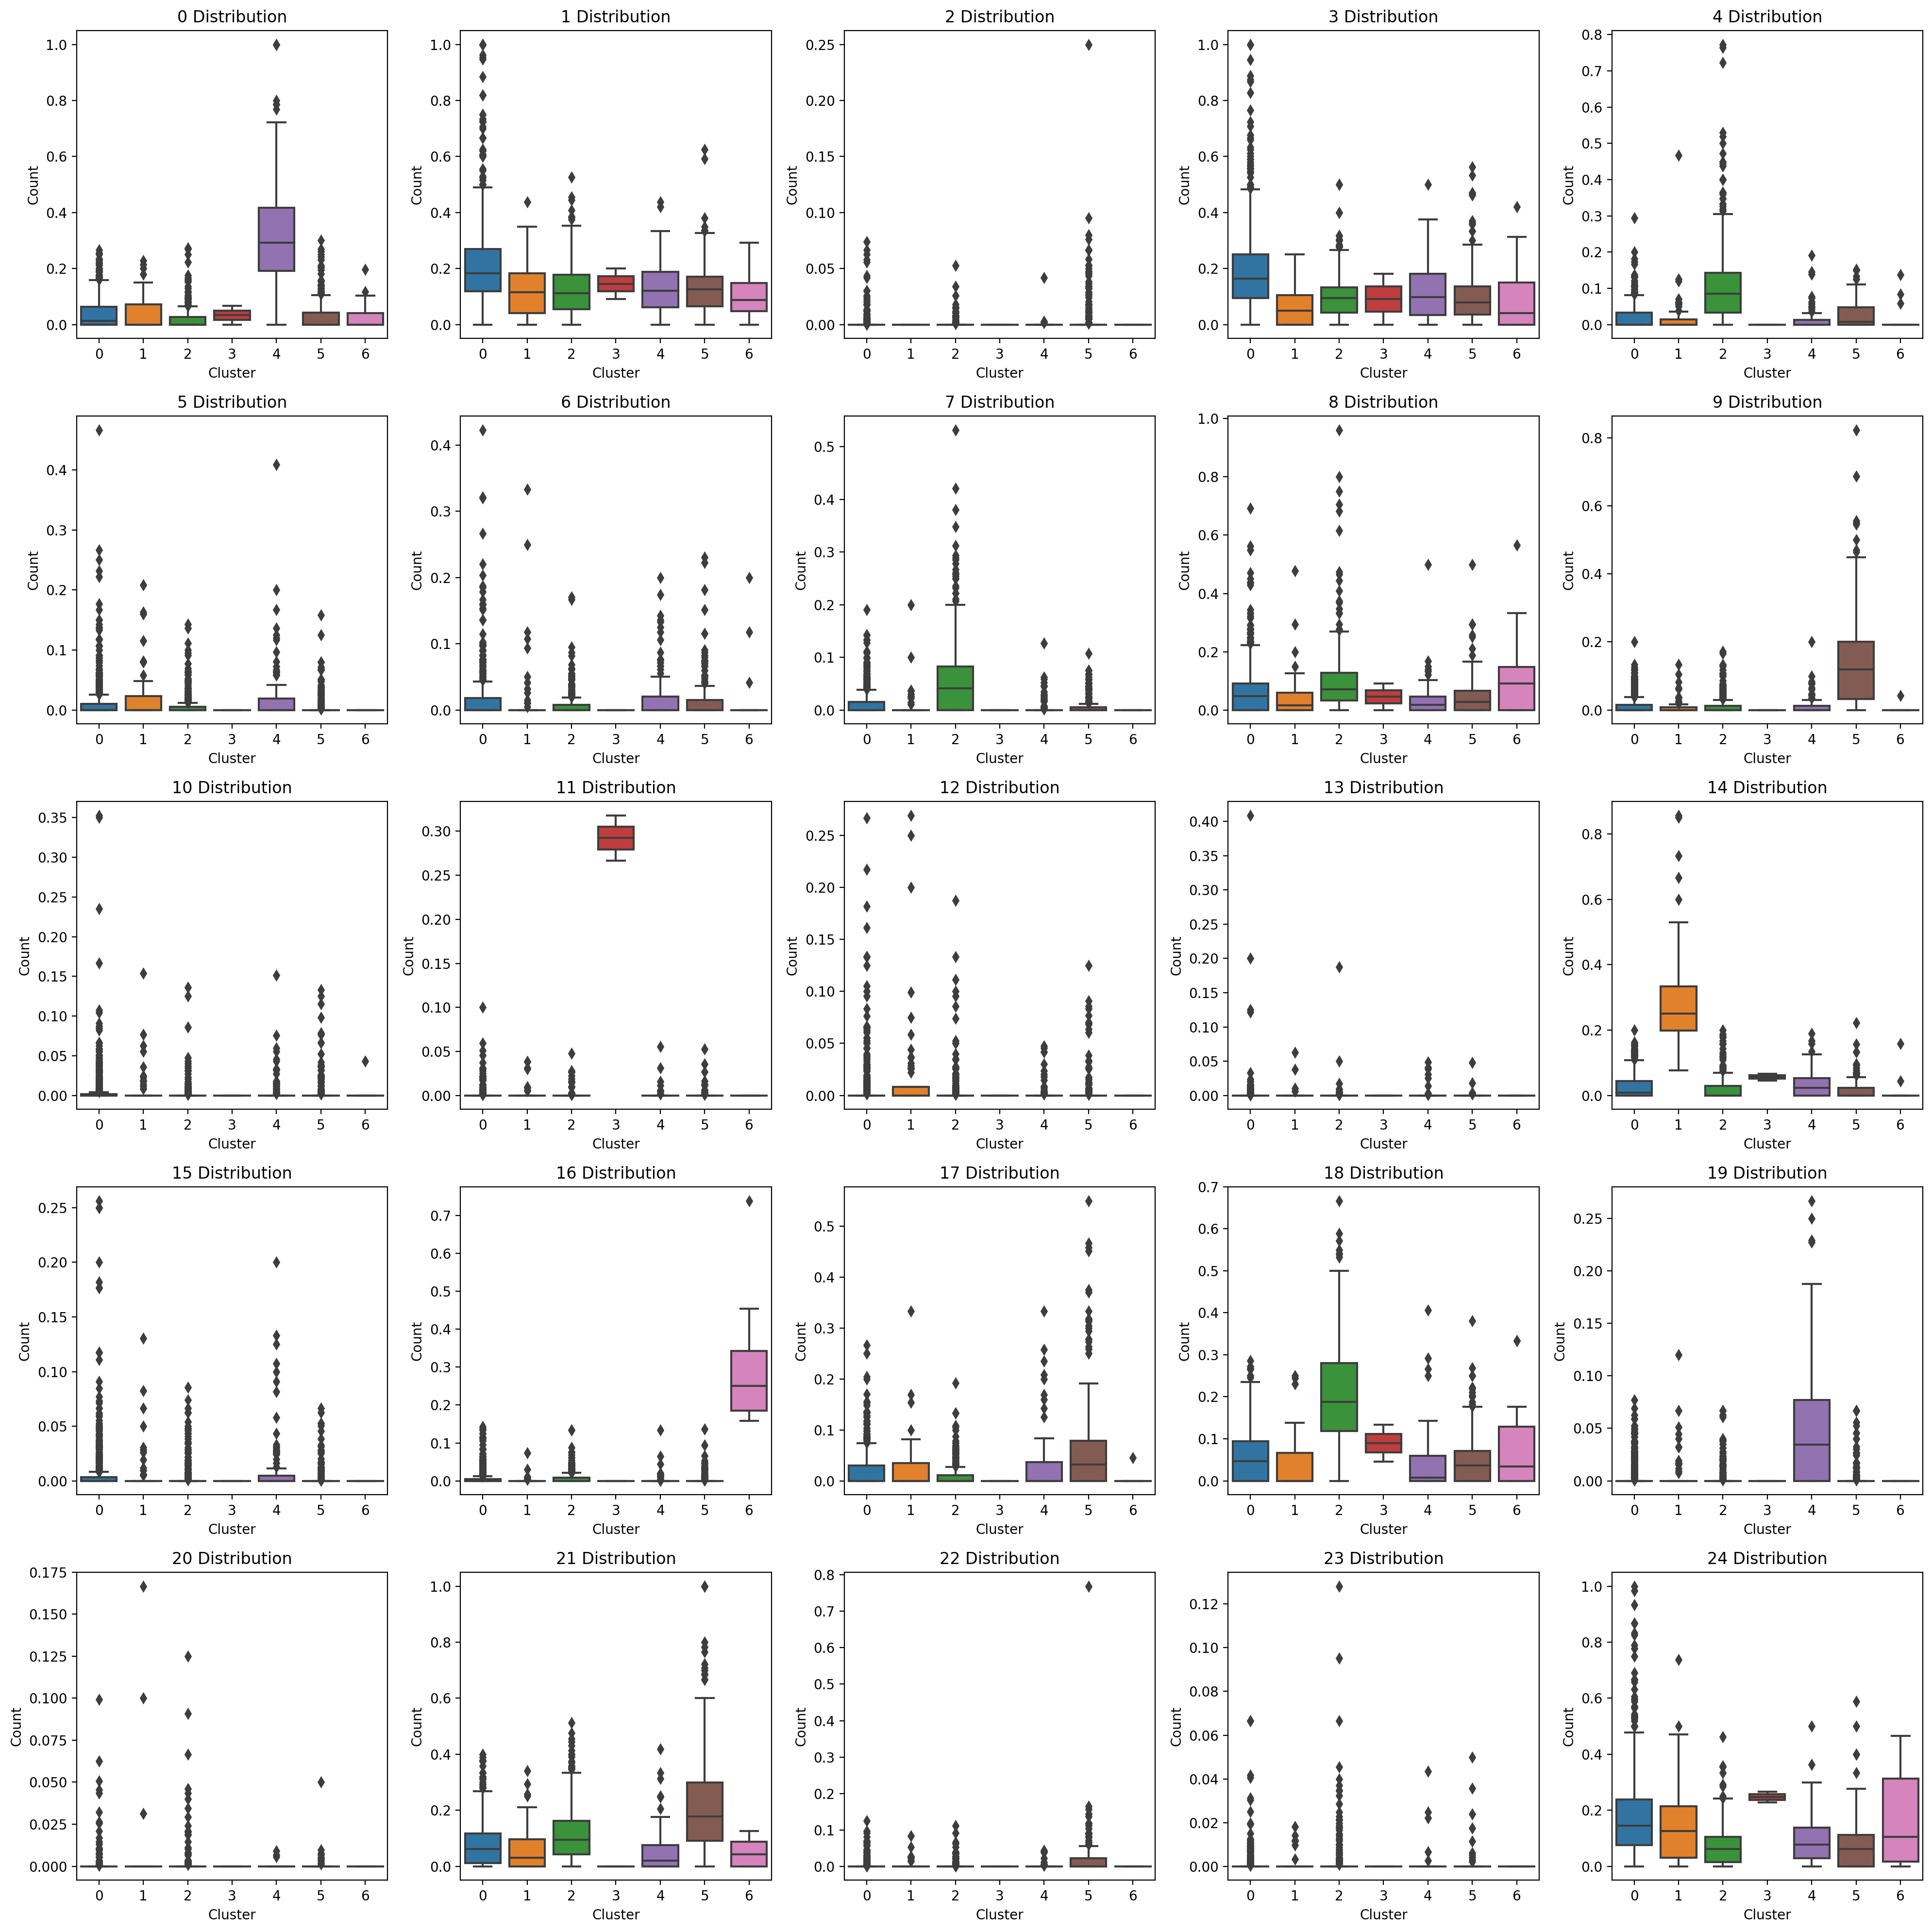

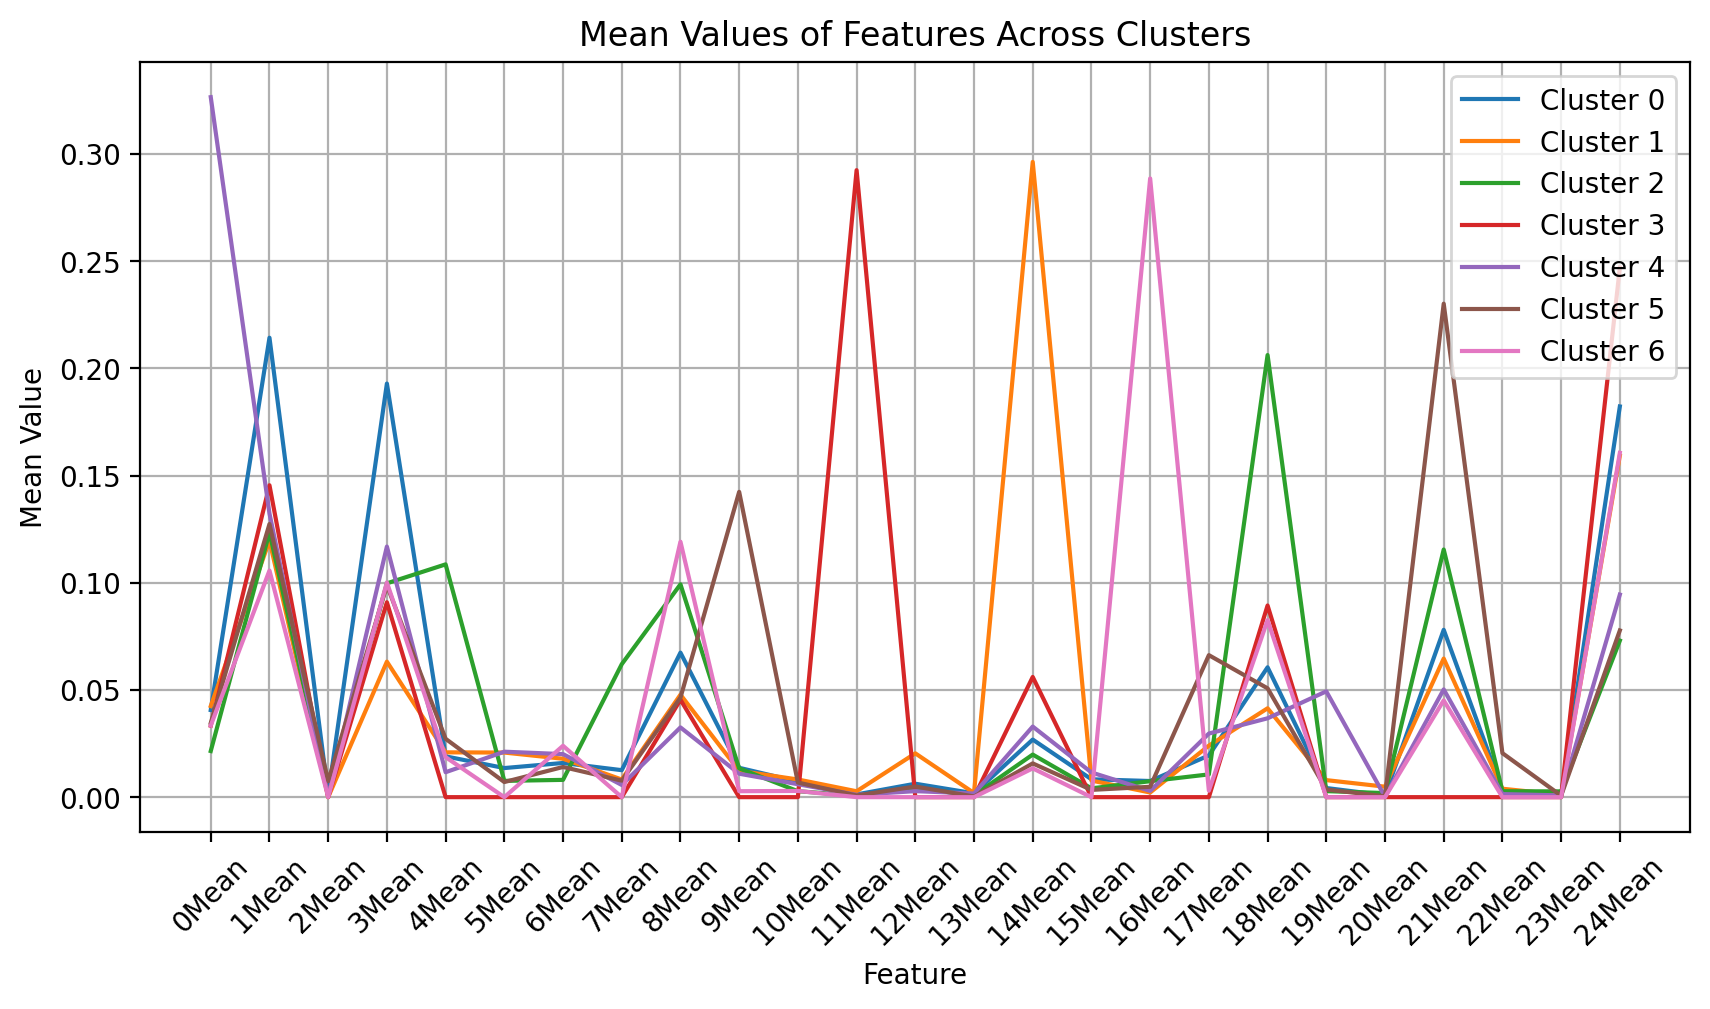

InterestsCluster  Count     0Mean     1Mean     2Mean     3Mean     4Mean  \
0                 0    673  0.040636  0.214267  0.001232  0.192895  0.019033   
1                 1     61  0.042478  0.119670  0.000000  0.063199  0.020899   
2                 2    359  0.021508  0.123542  0.000819  0.099727  0.108573   
3                 3      2  0.033333  0.145455  0.000000  0.090909  0.000000   
4                 4    121  0.326476  0.132278  0.000402  0.116883  0.011635   
5                 5    232  0.034595  0.127380  0.007474  0.098763  0.027223   
6                 6     15  0.033414  0.105693  0.000000  0.100153  0.018673   

      5Mean     6Mean     7Mean  ...    15Mean    16Mean    17Mean    18Mean  \
0  0.013571  0.015943  0.012588  ...  0.008340  0.007532  0.019445  0.060562   
1  0.020801  0.017913  0.008219  ...  0.007729  0.002175  0.024016  0.041444   
2  0.007593  0.008060  0.062012  ...  0.004111  0.007442  0.010619  0.206183   
3  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.089394   
4  0.021200  0.020075  0.005686  ...  0.011524  0.002906  0.029665  0.036778   
5  0.007049  0.014076  0.007704  ...  0.003393  0.004830  0.066233  0.050754   
6  0.000000  0.023954  0.000000  ...  0.000000  0.288565  0.003030  0.082550   

     19Mean    20Mean    21Mean    22Mean    23Mean    24Mean  
0  0.004263  0.000854  0.078047  0.003076  0.000964  0.182217  
1  0.007941  0.004884  0.064636  0.003927  0.001124  0.159276  
2  0.002804  0.001906  0.115506  0.002756  0.002688  0.073015  
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.246970  
4  0.049347  0.000179  0.050243  0.001425  0.000823  0.094475  
5  0.003562  0.000412  0.230151  0.020530  0.000685  0.077754  
6  0.000000  0.000000  0.045139  0.000000  0.000000  0.160584  

[7 rows x 27 columns]

In [19]:
clustering_features = list(range(25))
clustering_name = 'InterestsCluster'

custom_cluster(users_with_all_attributes, clustering_features, 7, clustering_name, verbose=True, minmax=False)

In [18]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.08443853077021701
p-value: 0.000999000999000999
